<a href="https://colab.research.google.com/github/jhanv/TLDR/blob/main/tldr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TL DR, which is short for “too long; didn't read”, first originated on Reddit. It is used to mark comments with a short brief or summary for very long posts that people don't have the time to read.
This project is to generate TLDR for the articles/ posts (from reddit) 

#### Checking the Runtime and GPU Rquirements on colab notebook

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Apr 29 16:39:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('High-RAM runtime!') 

Your runtime has 27.4 gigabytes of available RAM

High-RAM runtime!


## Importing the Libraries

Installing the datasets module

In [ ]:
!pip install datasets
!pip install -q tfds-nightly tensorflow matplotlib

In [ ]:
!pip install tokenizer
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import datasets

In [ ]:
from collections import Counter 
from wordcloud import WordCloud, STOPWORDS 
import re 
import string
import nltk # preprocessing text
nltk.download('stopwords')
from textblob import TextBlob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import argparse
import pickle
import random
import time
import datetime
from datetime import datetime

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import Dataset, TensorDataset

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tnrange, tqdm

In [ ]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel,AdamW, GPT2Tokenizer
from transformers import get_linear_schedule_with_warmup


In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Reading and Data Analysis


The dataset that will be used in this project is from subreddit on reddit named tifu which was scraped and loaded already into the tensorflow datasets module. 
The reddit data is loaded from their module using tfds.load() syntax.

The details about the dataset can be found here 
https://www.tensorflow.org/datasets/catalog/reddit_tifu

### Loading the dataset

In [ ]:
%%time

# Reading/ loading the datset form the tensorflow datasets
dataset, info = tfds.load('reddit_tifu', split='train', shuffle_files=True , with_info=True)
# Converting teh datset into a Dataframe
data = tfds.as_dataframe(dataset, info)
data

INFO:absl:No config specified, defaulting to first: reddit_tifu/short
INFO:absl:Load dataset info from /root/tensorflow_datasets/reddit_tifu/short/1.1.0
INFO:absl:Reusing dataset reddit_tifu (/root/tensorflow_datasets/reddit_tifu/short/1.1.0)
INFO:absl:Constructing tf.data.Dataset reddit_tifu for split train, from /root/tensorflow_datasets/reddit_tifu/short/1.1.0


CPU times: user 34 s, sys: 6.31 s, total: 40.3 s
Wall time: 23.3 s


### Information about the dataset
Finding the information about the dataset

In [ ]:
data.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 79740 entries, 0 to 79739
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   documents     79740 non-null  object 
 1   num_comments  79740 non-null  float64
 2   score         79740 non-null  float64
 3   title         79740 non-null  object 
 4   tldr          79740 non-null  object 
 5   ups           79740 non-null  float64
 6   upvote_ratio  79740 non-null  float64
dtypes: float64(4), object(3)
memory usage: 4.3+ MB


Since the project goal is to get the tldr given the post/ the long post, we are filtering the data which has the tdlr.

### Filtering the Data

In [ ]:
df_tldr = data[data["tldr"] != b'']
df_tldr.to_csv("df_tldr.csv")

In [ ]:
# Finding the length of the each post length of the document in filtered dataframe
df_tldr["len_post"] = df_tldr["documents"].apply(lambda line : len(line))
df_tldr["len_tldr"] = df_tldr["tldr"].apply(lambda line : len(line))
df_tldr["len_title"]  = df_tldr["title"].apply(lambda line : len(line))


In [ ]:
def printlen(text, col):
  """
  Input : Just the text to be printed and the column name 
  --> text : string
  --> col : string
  Function to print max/min of the number of words in the column
  """
  print(text, "Max Length", max(df_tldr[col]), "Min Length", min(df_tldr[col]))

printlen("Post Max length", "len_post")
printlen("Tldr Max length", "len_tldr")
printlen("Title Max length", "len_title")

df_tldr = df_tldr[(df_tldr["len_post"] > 100) & (df_tldr["len_title"] > 8) & (df_tldr["len_tldr"] > 3) ]

print("\nAfter")
printlen("Post Max length", "len_post")
printlen("Tldr Max length", "len_tldr")
printlen("Title Max length", "len_title")

Post Max length Max Length 32289 Min Length 3
Tldr Max length Max Length 2319 Min Length 1
Title Max length Max Length 289 Min Length 2

After
Post Max length Max Length 32289 Min Length 103
Tldr Max length Max Length 2207 Min Length 4
Title Max length Max Length 289 Min Length 9


The text is of type bytes, converting the text to string for the columns document, title, tldr

In [ ]:
df_tldr['tldr'] = df_tldr['tldr'].apply(lambda x : str(x)[2:-1])
df_tldr['title'] = df_tldr['title'].apply(lambda x : str(x)[2:-1])
df_tldr['documents'] = df_tldr['documents'].apply(lambda x : str(x)[2:-1])

### Data Exploration and Visualization

Finding the correlation of the dataframe between upvotes, score, ups etc. by plotting the correlation matrix

#### Correlation Matrix

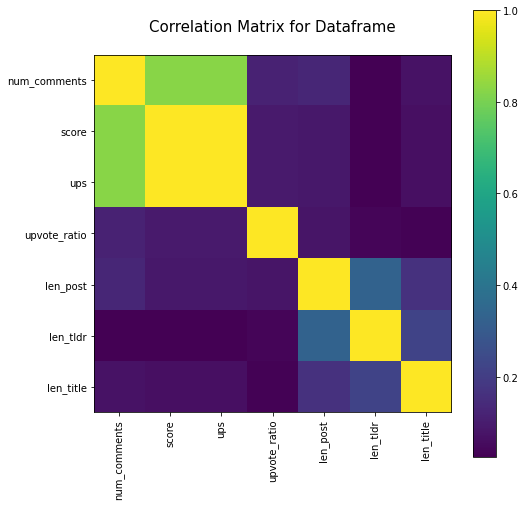

In [ ]:
corr = df_tldr.corr()
plt.figure(figsize=(8,8))
plt.matshow(corr, fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns, rotation=0)
plt.gca().xaxis.tick_bottom()
plt.colorbar()
plt.title(f'Correlation Matrix for Dataframe', fontsize = 15)
plt.show()

From the correlation matrix it can be seen that the score and the ups are very highly correlated but the len_post is slightly negatively corelated with the upvote ration which signifies the posts that are lengthy are probably not read. 

#### Word Cloud

In [ ]:
nltk_stopwords = nltk.corpus.stopwords.words('english')
punctuations = list(string.punctuation)
# curse = ["fuck", "jerk", "asshole", "boobs", "cunt", "butt", "penis", "shit"]
stopwords = set(nltk_stopwords).union(punctuations)

# Function to remove the stopwords and punctuations
def preprocess(x):
    """
    Function to remove the stopwords and punctuations
    """
    x = re.sub('[^a-z\s]', '', x.lower())                  
    x = [w for w in x.split() if w not in set(stopwords)]  
    return ' '.join(x)

In [ ]:
tldr = df_tldr['tldr'].apply(preprocess)
title = df_tldr['title'].apply(preprocess)
docs = df_tldr['documents'].apply(preprocess)

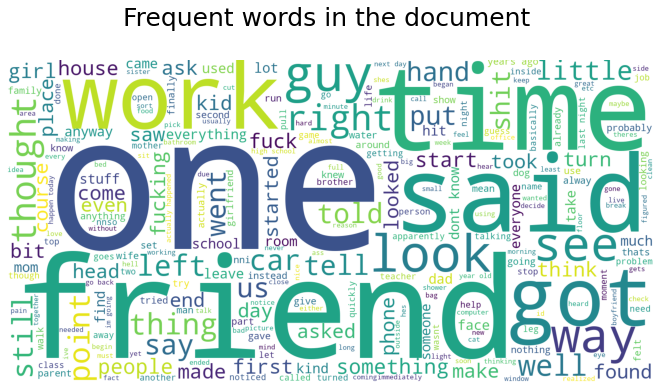

In [ ]:
wordcloud = WordCloud(width=1600, height=800, random_state=2, max_words=250, background_color='white',)
wordcloud.generate(str(set(docs)))
# declare our figure 
plt.figure(figsize=(16,8))
plt.title("Frequent words in the document \n", fontsize=25, color='black')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

#### Distribution of the data

In [ ]:
def dist_plot(data, label, title) :
  """
  Input : dataframe, labels to be given to the plot, title of the plot
  For plotting the distribution of the data of any column/s usinng historgram 
  """
  plt.hist(data, label = label)
  plt.xlabel("word length")
  plt.ylabel("frequency")
  plt.title(title)
  plt.legend()
  plt.show()

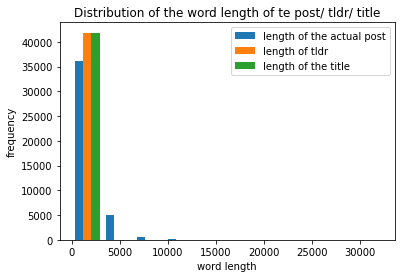

In [ ]:
dist_plot([df_tldr['len_post'], df_tldr['len_tldr'], df_tldr['len_title']], ["length of the actual post", "length of tldr", "length of the title"], "Distribution of the word length of te post/ tldr/ title")

In [ ]:
df_tldr.describe()

num_comments         score  ...      len_tldr     len_title
count  41839.000000  41839.000000  ...  41839.000000  41839.000000
mean      43.866369    324.497359  ...    109.148426     37.649514
std      173.340577   1938.187358  ...     66.804408     19.279411
min        0.000000      0.000000  ...      4.000000      9.000000
25%        3.000000      3.000000  ...     66.000000     24.000000
50%        8.000000     12.000000  ...     96.000000     34.000000
75%       21.000000     53.000000  ...    136.000000     46.000000
max     4506.000000  85249.000000  ...   2207.000000    289.000000

[8 rows x 7 columns]

In [ ]:
print("95 percentile of the length of the actual post is", df_tldr['len_post'].quantile(q = 0.95))
print("95 percentile of the length of the tldr is", df_tldr['len_tldr'].quantile(q = 0.95))
print("95 percentile of the length of the title is", df_tldr['len_title'].quantile(q = 0.95))

95 percentile of the length of the actual post is 4661.0999999999985
95 percentile of the length of the tldr is 229.0
95 percentile of the length of the title is 74.0


Ignoring 0.01 percentile of the data (which is an extreme case/ outlier) for better visualization of the distribution of the length of the posts

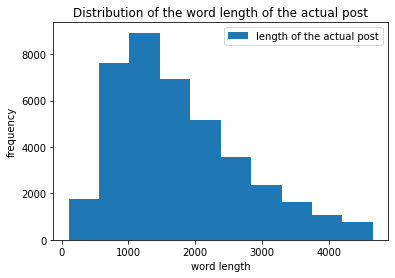

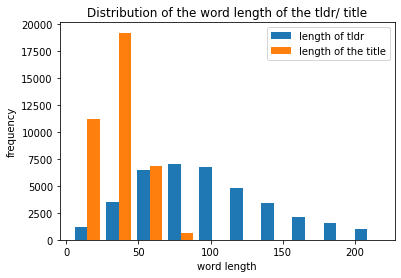

In [ ]:
df_tldr = df_tldr[df_tldr["len_post"] <= df_tldr['len_post'].quantile(q = 0.95)]

len_post = df_tldr['len_post']
len_tldr = df_tldr[df_tldr["len_tldr"] <= df_tldr['len_tldr'].quantile(q = 0.95)]['len_tldr']
len_title = df_tldr[df_tldr["len_title"] <= df_tldr['len_title'].quantile(q = 0.95)]['len_title']

dist_plot([len_post], ["length of the actual post"], "Distribution of the word length of the actual post")
dist_plot([len_tldr, len_title], ["length of tldr", "length of the title"], "Distribution of the word length of the tldr/ title")

In [ ]:
df_tldr.shape

(39747, 10)

In [ ]:
# df_tldr = df_tldr[(df_tldr["len_post"] <= df_tldr['len_post'].quantile(q = 0.85)) & (df_tldr["len_tldr"] <= df_tldr['len_tldr'].quantile(q = 0.85)) & (df_tldr["len_title"] <= df_tldr['len_title'].quantile(q = 0.85)) & (df_tldr["len_post"] >= df_tldr['len_post'].quantile(q = 0.15)) & (df_tldr["len_tldr"] >= df_tldr['len_tldr'].quantile(q = 0.15)) & (df_tldr["len_title"] >= df_tldr['len_title'].quantile(q = 0.15)) & (df_tldr["len_post"] > df_tldr['len_tldr'])]
df_tldr.shape


(39747, 10)

In [ ]:
df_tldr = df_tldr[(df_tldr["len_post"] <= df_tldr['len_post'].quantile(q = 0.85)) & (df_tldr["len_tldr"] <= df_tldr['len_tldr'].quantile(q = 0.85)) &  (df_tldr["len_post"] >= df_tldr['len_post'].quantile(q = 0.15)) & (df_tldr["len_tldr"] >= df_tldr['len_tldr'].quantile(q = 0.15)) & (df_tldr["len_post"] > df_tldr['len_tldr'])]

## Preprocessing


Replacing the Contractions with the full words

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

Cleaning the text
> Converting text to lowercase,    
> Mapping contracts to full text,  
> Remove text in paranthesis,    
> Remove special characters

In [ ]:
def clean_text(text, rmstop = False):
  """
  Input : The text or sentence/s to be cleaned and if stopwords has to be removed or not
  --> text : string
  --> rmstop : bool
  Cleans the text by 
  # - Converting text to lowercase,
  - Mapping contracts to full text,
  - Remove text in paranthesis,
  - Remove specific special characters
  - Remove newline character
  Output : Cleand text or sentence/s
  """
  # txt = text.lower()
  # txt = [' '.join(line.strip().split()) for line in text]
  txt = re.sub(r'\([^)]*\)', '', text)
  txt = re.sub('"', '', txt)
  txt = txt.replace("\\", "")
  txt = re.sub(r"'s\b","",txt)
  txt = ' '.join([contraction_mapping[word] if word in contraction_mapping else word for word in txt.split(" ")])
  # txt = re.sub("[^a-zA-Z]", " ", txt) 
  # txt = re.sub('[m]{2,}', 'mm', txt)
  txt = txt.rstrip().lstrip();
  nltk_sw = set(nltk_stopwords).union(stopwords)
  if rmstop:
    tokens = [word for word in txt.split() if not word in set(nltk_sw)]
  else:
    tokens = txt.split()
  
  return (" ".join(tokens)).strip()


In [ ]:
def clean_implement(df, colname):
  """
  Input: Dataframe and the column name
  --> df - datarame
  --> colname - string
  Loops through each row in the columns and applies the  clean_text() function to the content in the row
  Output: List of length = len(df) cleaned text
  """
  cleaned_text = []
  for text in df[colname]:
      cleaned_text.append(clean_text(text, False))
  return cleaned_text


In [ ]:
df_tldr["documents_cleaned"] = clean_implement(df_tldr, 'documents')
df_tldr["tldr_cleaned"] = clean_implement(df_tldr, 'tldr')
df_tldr["title_cleaned"] = clean_implement(df_tldr, 'title')

In [ ]:
df_tldr["documents_cleaned"]

1        me and a friend decided to go to the beach las...
3        obligatory this happened last thursday. nni wa...
5        this was actually a few years ago .nn i had my...
15       this is my first post on reddit, so i am sorry...
28       so this happened two days ago, i was browsing ...
                               ...                        
79725    this happened about a year ago. my friend, we ...
79729    i fucked up 8 minutes ago. it was a slow day a...
79730    literally happened about 2 hours ago. i got up...
79733    so my wife has cancer which is likely treatabl...
79738    this actually happened a few years ago, well a...
Name: documents_cleaned, Length: 20285, dtype: object

### Selecting the required columns for training 
i.e., for now just the document columns and tldr

We can change the tldr to title if we want to predict the title

In [ ]:
summary = "tldr_cleaned"
df = df_tldr[["documents_cleaned", summary ]]
# df['tldr_cleaned'] = df['tldr_cleaned'].apply(lambda x : 'sostok '+ x + ' eostok')
df.to_csv('cleaneddf.csv')
df.to_json('cleaneddf.json')
print("Shape of the datafarme",df.shape)

Shape of the datafarme (20285, 2)


### Preparing the Dataset

#### Tokenizer

Applying random start and endtoken to the tldr
Default tokenizer used is GPT2Tokenizer

In [ ]:
def add_tokens():
  """Returns GPT2 Tokeizer after adding sperator and pandding tokens"""
  tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
  special_tokens = {'pad_token':'<|pad|>','sep_token':'<|sep|>'}
  num_add_toks = tokenizer.add_special_tokens(special_tokens)
  return tokenizer

In [ ]:
def tokenize(data, summary):
  data["documents_cleaned"] = data["documents_cleaned"].apply(lambda x : np.array(tokenizer.encode(x , max_length = 1024, truncation=True)))
  data[summary] = data[summary].apply(lambda x : np.array(tokenizer.encode(x, max_length = 1024, truncation=True)))
  # lst = []
  # length = []
  # for i in range(len(data)):
  #   text = tokenizer.encode(tokenizer.pad_token, max_length = 1024, truncation=True)*1024
  #   content = np.append(np.append(data["documents_cleaned"].iloc[i], tokenizer.encode(tokenizer.sep_token, max_length = 1024, truncation=True)),data[summary].iloc[i])
  #   if len(content) > 1020 :
  #     continue
  #   text[:len(content)] = content
  #   text = torch.tensor(text)
  #   lst.append(text)
  #   length.append(len(data["documents_cleaned"].iloc[i]))
  # data_new = pd.DataFrame()
  # data_new["post"] = lst
  # data_new["sum_idx"] = length
  return data

In [ ]:
tokenizer = add_tokens()
ddf = df.copy()

In [ ]:
%%time
new_df = tokenize(ddf, summary)

CPU times: user 36.7 s, sys: 81.2 ms, total: 36.8 s
Wall time: 36.7 s


Dataset Preparation for the DataLoader

In [ ]:
class GPT21024Dataset(Dataset):

    def __init__(self,data, mode='train',length=None):
        self.data = data
        self.idxs = list(self.data.index)
        self.mode = mode
        if len == None:
            self.len = len(self.idxs)
        else:
            self.len = length

    def __len__(self):
        return self.len

    def __getitem__(self,idx):
        # print("before",idx, self.idxs)
        # if self.mode=='valid':
        #     idx = self.idxs[-idx]
        # elif self.mode=='test':
        #     idx = self.idxs[-idx-self.len]   #assuming valid and test set of same sizes
        # else:
        #     idx = self.idxs[idx]
        # print("after",idx)
        text = tokenizer.encode(tokenizer.pad_token, max_length = 1024, truncation=True)*1024
        content = np.append(np.append(self.data["documents_cleaned"].iloc[idx], tokenizer.encode(tokenizer.sep_token, max_length = 1024, truncation=True)),self.data["tldr_cleaned"].iloc[idx])
        if len(content) > 1022 :
          content = content[:1024]
        text[:len(content)] = content
        text = torch.tensor(text)

        sample = {'post': text, 'sum_idx': len(self.data["documents_cleaned"].iloc[idx])}
        return sample

In [ ]:
train_size, val_size, test_size = int(len(new_df)*0.95), int(len(new_df)*0.025), int(len(new_df)*0.025)
print("train_size, val_size, test_size -->", train_size, val_size, test_size )

train_size, val_size, test_size --> 19270 507 507


## Training

In [ ]:
# default arguments 

parser = argparse.ArgumentParser()
parser.add_argument("--lr",default=5e-4, type=float, help="learning rate")
parser.add_argument("--seed",default=42, type=int,  help="seed to replicate results")
parser.add_argument("--n_gpu",default=1, type=int,  help="no of gpu available")
parser.add_argument("--gradient_accumulation_steps",default=2, type=int, help="gradient_accumulation_steps")
parser.add_argument("--batch_size",default=1, type=int,  help="batch_size")
parser.add_argument("--num_workers",default=4, type=int,  help="num of cpus available")
parser.add_argument("--device",default=torch.device('cuda'), help="torch.device object")
parser.add_argument("--num_train_epochs",default=10, type=int,  help="no of epochs of training")
parser.add_argument("--output_dir",default='./output', type=str,  help="path to save evaluation results")
parser.add_argument("--model_dir",default='./weights', type=str,  help="path to save trained model")
parser.add_argument("--max_grad_norm",default=2.0, type=float, help="max gradient norm.")
parser.add_argument("--root_dir",default='./tldr/gpt2_1024_data', type=str, help="location of json dataset.")
parser.add_argument("--ids_file",default='./tldr/ids.json', type=str, help="location of train, valid and test file indexes")
parser.add_argument("--max_steps", default=-1, type=int, help="If > 0: set total number of training steps to perform. Override num_train_epochs.")
args = parser.parse_args([])
print(args)


Namespace(batch_size=1, device=device(type='cuda'), gradient_accumulation_steps=2, ids_file='./tldr/ids.json', lr=0.0005, max_grad_norm=2.0, max_steps=-1, model_dir='./weights', n_gpu=1, num_train_epochs=10, num_workers=4, output_dir='./output', root_dir='./tldr/gpt2_1024_data', seed=42)


In [ ]:
def top_k_top_p_filtering(logits, top_k=30, top_p=0.9, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Input:
        --> logits: logits distribution shape (vocabulary size)
        --> top_k > 0: keep only top k tokens with highest probability (top-k filtering).
        --> top_p > 0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
        From: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits


In [ ]:
def sample_seq(model, context, length, device, temperature=0.7, top_k=25, top_p=0.9):
    """ Generates a sequence of tokens 
        Input:
        --> model: gpt/gpt2 model
        --> context: tokenized text using gpt/gpt2 tokenizer
        --> length: length of generated sequence.
        --> device: torch.device object.
        --> temperature >0: used to control the randomness of predictions by scaling the logits before applying softmax.
        --> top_k > 0: keep only top k tokens with highest probability (top-k filtering).
        --> top_p > 0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
    """
    
    context = torch.tensor(context, dtype=torch.long, device=device)
    context = context.unsqueeze(0)
    generated = context[:1024]
    with torch.no_grad():  
        for _ in tnrange(length):
            inputs = {'input_ids': generated}
            outputs = model(**inputs)  # Note: we could also use 'past' with GPT-2/Transfo-XL/XLNet (cached hidden-states)
            next_token_logits = outputs[0][0, -1, :] / temperature
            filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
            next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
            generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
    return generated

In [ ]:
def generate_sample(data, tokenizer, model, num=1, eval_step=False, length=100, temperature=0.6, top_k=25, top_p=0.9, device=torch.device('cuda')):
    """ Generate summaries for "num" number of posts.
        Args:
            data = GPT21024Dataset object
            tokenizer = gpt/gpt2 tokenizer
            model = gpt/gpt2 model
            num = number of posts for which summaries has to be generated
            eval_step = can be True/False, checks generating during evaluation or not
    """
    for i in range(num):
        sample = data[i]
        idx = sample['sum_idx']
        context = sample['post'][:idx].tolist()
        summary = sample['post'][idx+1:][:100].tolist()
        generated_text = sample_seq(model, context, length, device, temperature, top_k, top_p)
        generated_text = generated_text[0, len(context):].tolist()
        text = tokenizer.convert_ids_to_tokens(generated_text,skip_special_tokens=True)
        text = tokenizer.convert_tokens_to_string(text)
        if eval_step==False:
            print('new_post', end='\n\n')
            print(tokenizer.decode(context), end='\n\n')
            print("generated_summary", end='\n\n')
            print(text, end='\n\n')
            print('actual_summary', end='\n\n')
            print(tokenizer.decode(summary), end='\n\n')
        else:
            print('new_post', end='\n\n')
            print(tokenizer.decode(context), end='\n\n')
            print("generated_summary", end='\n\n')
            print(text, end='\n\n')

In [ ]:
def train(args, tokenizer, model, train_data, val_data, loss_fct, optimizer, scheduler):
  """ Trains the model
        Input:
        --> args: dict that contains all the necessary information passed by user while training
        --> tokenizer: GPT2Tokenizer + special tokens
        --> model: finetuned gpt/gpt2 model
        --> train_data: GPT21024Dataset object for train data
        --> val_data: GPT21024Dataset object for validation data
        --> loss_fct:CrossEntropyLoss
        --> optimizer: AdamW
        --> scheduler: get_linear_schedule_with_warmup
        --> global_step: no. of times gradients have backpropagated
        --> ignore_index: token not considered in loss calculation
    """
  
  writer = SummaryWriter('./output/logs')
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=args.batch_size)
  

  global_step = 0
  train_loss, log_loss = 0.0, 0.0
  model.zero_grad()
  train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")
  set_seed(args)


  for _ in train_iterator:
      epoch_iterator = tqdm(train_dataloader, desc="training")
      for step, batch in enumerate(train_dataloader):
          inputs, labels = torch.tensor(batch['post']), torch.tensor(batch['post'])
          
          inputs = inputs.to(args.device)
          labels = labels.to(args.device)
          inputs = torch.tensor(inputs).to(torch.int64)
          labels = torch.tensor(labels).to(torch.int64)
          model.train()
          logits = model(inputs)[0]
          idx = batch['sum_idx'].item() # index of separator token
          shift_logits = logits[..., idx:-1, :].contiguous()
          shift_labels = labels[..., idx+1:].contiguous()
          loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
          loss = loss/args.gradient_accumulation_steps
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
          train_loss += loss.item()
          if (step + 1) % args.gradient_accumulation_steps == 0:
              optimizer.step()
              scheduler.step()  # Update learning rate schedule
              model.zero_grad()
              global_step += 1
              writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
              writer.add_scalar('loss', (train_loss - log_loss)/args.gradient_accumulation_steps, global_step)
              log_loss = train_loss
              # print("loss:", loss.item(), end='\n\n')
              if (step + 1) % (100*args.gradient_accumulation_steps) == 0:
                print("loss:", loss.item(), end='\n\n')
              if (step + 1)/args.gradient_accumulation_steps == 1.0:
                print('After 1st update: ', end='\n\n')
                # generate_sample(train_data, tokenizer, model, num=2, eval_step=False)
                generate_sample(valid_data, tokenizer, model, num=2, eval_step=False)

              
          if (step + 1) % (1000*args.gradient_accumulation_steps) == 0:
              results = evaluate(args, model, valid_data, ignore_index, global_step)
              for key, value in results.items():
                  writer.add_scalar('eval_{}'.format(key), value, global_step)
              print('After', global_step+1,'updates: ', end='\n\n')
              generate_sample(valid_data, tokenizer, model, num=2, eval_step=True)


In [ ]:
def evaluate(args, model, eval_dataset, ignore_index, global_step=None):
    """ Returns perplexity score on validation dataset.
        Input:
        --> args: dict that contains all the necessary information passed by user while training
        --> model: finetuned gpt/gpt2 model
        --> eval_dataset: GPT21024Dataset object for validation data
        --> global_step: no. of times gradients have backpropagated
        --> ignore_index: token not considered in loss calculation
    """

    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.batch_size)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation

    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = torch.tensor(batch['post']).to(args.device), torch.tensor(batch['post']).to(args.device)
        
        with torch.no_grad():
            logits = model(inputs)[0]
            idx = batch['sum_idx'].item() # index of separator token
            # only consider loss on reference summary just like seq2seq models
            shift_logits = logits[..., idx:-1, :].contiguous()
            shift_labels = labels[..., idx+1:].contiguous()
            lm_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = (eval_loss) / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {
        "perplexity": perplexity
    }
    print("perplexity:", perplexity.item())

    if global_step:
        output_eval_file = "eval_results.txt"
        with open(output_eval_file, "a") as f:
            for key in sorted(result.keys()):
                f.write('\n\n')
                f.write("time = %s, %s = %s, step = %s\n" % (datetime.now().strftime("%d/%m/%Y %H:%M:%S"), key, str(result[key]), str(global_step)))
    return result      

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))
model.to(args.device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [ ]:
ignore_index = tokenizer.pad_token_id

def set_seed(args):
    "sets the seed for the random functions"
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [ ]:
GPT21024Dataset(data = new_df[:train_size], mode='train', length=3000).__getitem__(1)

{'post': tensor([  672,  4604,  2870,  ..., 50257, 50257, 50257]),
 'sum_idx': 246}

In [ ]:
sample = {}

train_data = GPT21024Dataset(data = new_df[:train_size], mode='train', length=train_size) 
valid_data = GPT21024Dataset(data = new_df[train_size:train_size+ val_size],mode='valid',length=val_size) 
test_data = GPT21024Dataset(data = new_df[train_size+ val_size:train_size+ val_size+test_size],mode='test',length=test_size) 

In [ ]:
f = open("eval_results.txt", "w")
f.close()

In [ ]:
ignore_index = tokenizer.pad_token_id
loss_fct = CrossEntropyLoss(ignore_index=ignore_index)
optimizer = AdamW(model.parameters(),lr=args.lr)
scheduler = get_linear_schedule_with_warmup(optimizer,100,-1)
train(args, tokenizer, model,  train_data, valid_data, loss_fct, optimizer, scheduler )


training:   0%|          | 0/19270 [00:00<?, ?it/s]

After 1st update: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 to the the to

actual_summary

i forgot to check some settings and in turn we missed out on a potential customer. <|pad|> <|pad|> <|


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary



actual_summary

tifu by breaking my fathers bed which is made o



Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]

Evaluating:   0%|          | 2/507 [00:00<00:32, 15.31it/s]

loss: 2.2314672470092773





Evaluating:   1%|          | 4/507 [00:00<00:33, 15.21it/s]

Evaluating:   1%|          | 6/507 [00:00<00:33, 15.13it/s]

Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.06it/s]

Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.06it/s]

Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.08it/s]

Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.05it/s]

Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.04it/s]

Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.05it/s]

Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.98it/s]

Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.00it/s]

Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.00it/s]

Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.97it/s]

Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.96it/s]

Evaluating:   6%|▌         | 30/507 [00:01<00:31, 14.97it/s]

Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.98it/s]

Evaluating:   7%|▋         | 34/507 [00:02<00:31, 15.00it/s]

Evaluatin

perplexity: 82.38459014892578
After 1001 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is also told about it. he does not have to add 1 product line to a list. i can onlyi tried toi tried toi tried tofor ai tried toa


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he took a week to fix it, now i have tofor a student in middle s



Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]

Evaluating:   0%|          | 2/507 [00:00<00:33, 15.18it/s]

loss: 2.8635005950927734





Evaluating:   1%|          | 4/507 [00:00<00:33, 15.11it/s]

Evaluating:   1%|          | 6/507 [00:00<00:33, 15.04it/s]

Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.05it/s]

Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.00it/s]

Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.03it/s]

Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.07it/s]

Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.07it/s]

Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.89it/s]

Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.94it/s]

Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.95it/s]

Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.96it/s]

Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.97it/s]

Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.98it/s]

Evaluating:   6%|▌         | 30/507 [00:02<00:31, 15.00it/s]

Evaluating:   6%|▋         | 32/507 [00:02<00:31, 15.01it/s]

Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.99it/s]

Evaluatin

perplexity: 82.38459014892578
After 2001 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is only trying toi tried toi tried toi tried toi tried toi to check oni got ai, i ended up trying toing out thei. they were told 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 got it out. got it out, got it out, broke the man's bed, broke h



Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]

Evaluating:   0%|          | 2/507 [00:00<00:33, 15.30it/s]

loss: 1.929431438446045





Evaluating:   1%|          | 4/507 [00:00<00:33, 15.21it/s]

Evaluating:   1%|          | 6/507 [00:00<00:33, 15.11it/s]

Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.07it/s]

Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.02it/s]

Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.99it/s]

Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.99it/s]

Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.00it/s]

Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.99it/s]

Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.97it/s]

Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.94it/s]

Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.93it/s]

Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.93it/s]

Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.93it/s]

Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.96it/s]

Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.95it/s]

Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.97it/s]

Evaluatin

perplexity: 82.38459014892578
After 3001 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he says he has no inventory. he is looking for afor a client, he is not out. i. he has no inventory. he is not out. he has no invent


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of the bed. he told me to break his bed



Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]

Evaluating:   0%|          | 2/507 [00:00<00:33, 15.23it/s]

loss: 2.379894733428955





Evaluating:   1%|          | 4/507 [00:00<00:33, 15.14it/s]

Evaluating:   1%|          | 6/507 [00:00<00:33, 15.13it/s]

Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.09it/s]

Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.05it/s]

Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.01it/s]

Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.00it/s]

Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.01it/s]

Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.00it/s]

Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.98it/s]

Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.97it/s]

Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.98it/s]

Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.98it/s]

Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.98it/s]

Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.99it/s]

Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.98it/s]

Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.98it/s]

Evaluatin

perplexity: 82.38459014892578
After 4001 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i do not. i have to add ai cannot find an inventory piece he is looking for. i. he is looking for the items he is looking for. he is


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now he has told me to get it out of the bed. he tells me to do i



Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]

Evaluating:   0%|          | 2/507 [00:00<00:32, 15.46it/s]

loss: 2.218191623687744





Evaluating:   1%|          | 4/507 [00:00<00:32, 15.31it/s]

Evaluating:   1%|          | 6/507 [00:00<00:32, 15.23it/s]

Evaluating:   2%|▏         | 8/507 [00:00<00:32, 15.16it/s]

Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.00it/s]

Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.00it/s]

Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.99it/s]

Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.96it/s]

Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.99it/s]

Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.03it/s]

Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.00it/s]

Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.97it/s]

Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.99it/s]

Evaluating:   6%|▌         | 28/507 [00:01<00:31, 15.01it/s]

Evaluating:   6%|▌         | 30/507 [00:02<00:31, 15.02it/s]

Evaluating:   6%|▋         | 32/507 [00:02<00:31, 15.00it/s]

Evaluating:   7%|▋         | 34/507 [00:02<00:31, 15.00it/s]

Evaluatin

perplexity: 82.38459014892578
After 5001 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is now trying toi tried toi tried toi tried toi tried toi, failed to find all possible client. he is now trying to sell ai-listed


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 has no idea how to break his bed, has no idea how toi broke his 



Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]

Evaluating:   0%|          | 2/507 [00:00<00:33, 15.22it/s]

loss: 2.4080770015716553





Evaluating:   1%|          | 4/507 [00:00<00:33, 15.12it/s]

Evaluating:   1%|          | 6/507 [00:00<00:33, 15.08it/s]

Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.05it/s]

Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.03it/s]

Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.04it/s]

Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.04it/s]

Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.03it/s]

Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.03it/s]

Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.04it/s]

Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.05it/s]

Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.05it/s]

Evaluating:   5%|▌         | 26/507 [00:01<00:32, 15.02it/s]

Evaluating:   6%|▌         | 28/507 [00:01<00:31, 15.04it/s]

Evaluating:   6%|▌         | 30/507 [00:01<00:31, 15.07it/s]

Evaluating:   6%|▋         | 32/507 [00:02<00:31, 15.07it/s]

Evaluating:   7%|▋         | 34/507 [00:02<00:31, 15.06it/s]

Evaluatin

perplexity: 82.38459014892578
After 6001 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i cannot find ai tried toi tried toi tried toi toi tried toi to sell 2nd product line to a client. it takesi has to find ai-i got a 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of the bed. he told me to break his bed



Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]

Evaluating:   0%|          | 2/507 [00:00<00:33, 15.14it/s]

loss: 2.3780734539031982





Evaluating:   1%|          | 4/507 [00:00<00:33, 15.02it/s]

Evaluating:   1%|          | 6/507 [00:00<00:33, 14.98it/s]

Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.93it/s]

Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.88it/s]

Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.90it/s]

Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.90it/s]

Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.91it/s]

Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.92it/s]

Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.89it/s]

Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.89it/s]

Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.86it/s]

Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.85it/s]

Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.85it/s]

Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.84it/s]

Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.80it/s]

Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.84it/s]

Evaluatin

perplexity: 82.38459014892578
After 7001 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i. took ai. took a sample of ai. did not tried toi. failed to find the inventory piece he is looking for. i. turned out he is out he


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now he has got his man hands on it. is now trying toi tried to g



Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]

Evaluating:   0%|          | 2/507 [00:00<00:32, 15.36it/s]

loss: 2.408118486404419





Evaluating:   1%|          | 4/507 [00:00<00:33, 15.15it/s]

Evaluating:   1%|          | 6/507 [00:00<00:33, 15.08it/s]

Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.99it/s]

Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.88it/s]

Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.92it/s]

Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.89it/s]

Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.92it/s]

Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.85it/s]

Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.88it/s]

Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.91it/s]

Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.87it/s]

Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.85it/s]

Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.83it/s]

Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.82it/s]

Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.83it/s]

Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.84it/s]

Evaluatin

perplexity: 82.38459014892578
After 8001 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is trying toi tried toi tried toi tried toi tried toi tried toi tried toi tried toi, i ended up trying to buyi was able to buyi, 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i have toi tried to break his bed. ended up breaking his bed



Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]

Evaluating:   0%|          | 2/507 [00:00<00:33, 15.28it/s]

loss: 2.1202874183654785





Evaluating:   1%|          | 4/507 [00:00<00:33, 15.16it/s]

Evaluating:   1%|          | 6/507 [00:00<00:33, 15.12it/s]

Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.06it/s]

Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.96it/s]

Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.98it/s]

Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.94it/s]

Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.82it/s]

Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.86it/s]

Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.87it/s]

Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.87it/s]

Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.88it/s]

Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.87it/s]

Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.86it/s]

Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.86it/s]

Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.83it/s]

Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.85it/s]

Evaluatin

perplexity: 82.38459014892578
After 9001 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is now trying toi tried toi tried toi tried toi tried toi tofor a client to buy a product line from a potential client. he is now


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out, he told me to break his bed. i broke h



training:   0%|          | 0/19270 [00:00<?, ?it/s]

After 1st update: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i. took 30 seconds to confirm, got, then, it is not a client he can't get ai has a. I missed ai. did not to check on every client. d


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 his brother said it is not a bane, and i broke his brother in th




Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]


Evaluating:   0%|          | 2/507 [00:00<00:33, 15.06it/s]

loss: 2.3279519081115723






Evaluating:   1%|          | 4/507 [00:00<00:33, 15.02it/s]


Evaluating:   1%|          | 6/507 [00:00<00:33, 14.97it/s]


Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.84it/s]


Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.84it/s]


Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.87it/s]


Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.88it/s]


Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.88it/s]


Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.86it/s]


Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.90it/s]


Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.85it/s]


Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.86it/s]


Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.86it/s]


Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.88it/s]


Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.87it/s]


Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.85it/s]


Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.87

perplexity: 82.38459014892578
After 10636 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i can't find ai tried toi tried toi tried toi tried toi tried toi tried toi tried to fix all clients. i would have to fix them. this


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 it has broken his bed, now his brother has told me to get it out




Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]


Evaluating:   0%|          | 2/507 [00:00<00:32, 15.38it/s]

loss: 2.4756903648376465






Evaluating:   1%|          | 4/507 [00:00<00:33, 15.20it/s]


Evaluating:   1%|          | 6/507 [00:00<00:33, 15.16it/s]


Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.06it/s]


Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.98it/s]


Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.99it/s]


Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.99it/s]


Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.95it/s]


Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.93it/s]


Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.94it/s]


Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.79it/s]


Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.82it/s]


Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.83it/s]


Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.83it/s]


Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.80it/s]


Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.80it/s]


Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.85

perplexity: 82.38459014892578
After 11636 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i can't tell you how it is, he says he is out. he is out. he is out. he is out. he is out. he is out. he is out. he is out. he is ou


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i tried to break his bed, ended up breaking his bed, broke his b




Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]


Evaluating:   0%|          | 2/507 [00:00<00:33, 15.21it/s]

loss: 2.1579439640045166






Evaluating:   1%|          | 4/507 [00:00<00:33, 15.07it/s]


Evaluating:   1%|          | 6/507 [00:00<00:33, 15.02it/s]


Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.98it/s]


Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.93it/s]


Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.95it/s]


Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.94it/s]


Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.92it/s]


Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.92it/s]


Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.88it/s]


Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.89it/s]


Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.90it/s]


Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.90it/s]


Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.86it/s]


Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.84it/s]


Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.88it/s]


Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.86

perplexity: 82.38459014892578
After 12636 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i do not have to add 2nd product line to a list. he has tofor a client, he is out onought to add 2nd product line to a list. he is o


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i broke his bed, broke his bed, broke his bed. then he told me t




Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]


Evaluating:   0%|          | 2/507 [00:00<00:33, 15.13it/s]

loss: 2.139087200164795






Evaluating:   1%|          | 4/507 [00:00<00:33, 15.04it/s]


Evaluating:   1%|          | 6/507 [00:00<00:33, 15.03it/s]


Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.97it/s]


Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.92it/s]


Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.91it/s]


Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.90it/s]


Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.86it/s]


Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.88it/s]


Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.85it/s]


Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.84it/s]


Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.85it/s]


Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.84it/s]


Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.89it/s]


Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.91it/s]


Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.93it/s]


Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.90

perplexity: 82.38459014892578
After 13636 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is not trying toi tried toi tried toi tried toi tried toi tried toi tried toat a client, he would have to add the 2nd product lin


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i broke his bed. was not grounded, he told me to get it out of t




Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]


Evaluating:   0%|          | 2/507 [00:00<00:33, 15.11it/s]

loss: 2.0273196697235107






Evaluating:   1%|          | 4/507 [00:00<00:33, 15.04it/s]


Evaluating:   1%|          | 6/507 [00:00<00:33, 14.97it/s]


Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.95it/s]


Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.87it/s]


Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.78it/s]


Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.80it/s]


Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.85it/s]


Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.86it/s]


Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.88it/s]


Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.88it/s]


Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.85it/s]


Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.86it/s]


Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.83it/s]


Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.83it/s]


Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.84it/s]


Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.86

perplexity: 82.38459014892578
After 14636 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he says he is not looking for afor a client, if he is not looking for a client, he is not looking for a client, he is not looking fo


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i tried to break his bed, he took a week to break it. has br




Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]


Evaluating:   0%|          | 2/507 [00:00<00:32, 15.39it/s]

loss: 2.2139129638671875






Evaluating:   1%|          | 4/507 [00:00<00:33, 15.18it/s]


Evaluating:   1%|          | 6/507 [00:00<00:33, 15.07it/s]


Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.01it/s]


Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.98it/s]


Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.96it/s]


Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.94it/s]


Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.89it/s]


Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.90it/s]


Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.83it/s]


Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.74it/s]


Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.81it/s]


Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.81it/s]


Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.83it/s]


Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.83it/s]


Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.85it/s]


Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.90

perplexity: 82.38459014892578
After 15636 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is a bit confused. he is a trader, he is a trader, he is a trader. he is not a trader, he is not a trader, he is a trader. he is 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i got it out of the bed. broke into his family house, broke 




Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]


Evaluating:   0%|          | 2/507 [00:00<00:33, 15.07it/s]

loss: 1.9127329587936401






Evaluating:   1%|          | 4/507 [00:00<00:33, 15.04it/s]


Evaluating:   1%|          | 6/507 [00:00<00:33, 15.02it/s]


Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.98it/s]


Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.92it/s]


Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.94it/s]


Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.94it/s]


Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.89it/s]


Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.89it/s]


Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.93it/s]


Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.88it/s]


Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.85it/s]


Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.84it/s]


Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.86it/s]


Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.90it/s]


Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.90it/s]


Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.91

perplexity: 82.38459014892578
After 16636 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is not sure he has to buyi told a potential client to buy a virtual interface, he is out. he is not sure he has to buyi told a po


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 got it out of the bed, broke it into a man-sized man-size man-si




Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]


Evaluating:   0%|          | 2/507 [00:00<00:33, 15.03it/s]

loss: 2.237748622894287






Evaluating:   1%|          | 4/507 [00:00<00:33, 14.99it/s]


Evaluating:   1%|          | 6/507 [00:00<00:33, 14.99it/s]


Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.85it/s]


Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.84it/s]


Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.86it/s]


Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.79it/s]


Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.81it/s]


Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.83it/s]


Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.86it/s]


Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.89it/s]


Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.88it/s]


Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.88it/s]


Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.90it/s]


Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.89it/s]


Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.88it/s]


Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.88

perplexity: 82.38459014892578
After 17636 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is looking for ai has to do a query of ai is out. he is trying to sell ai is out to buyi is out to buyi is out to buy ai is out t


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now he has no excuse. he has no excuse. he broke his bed, broke 




Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]


Evaluating:   0%|          | 2/507 [00:00<00:33, 14.95it/s]

loss: 2.5780251026153564






Evaluating:   1%|          | 4/507 [00:00<00:33, 14.91it/s]


Evaluating:   1%|          | 6/507 [00:00<00:33, 14.87it/s]


Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.90it/s]


Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.88it/s]


Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.90it/s]


Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.84it/s]


Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.87it/s]


Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.91it/s]


Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.97it/s]


Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.97it/s]


Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.90it/s]


Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.93it/s]


Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.93it/s]


Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.91it/s]


Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.88it/s]


Evaluating:   7%|▋         | 34/507 [00:02<00:31, 14.93

perplexity: 82.38459014892578
After 18636 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i. got ai. got ai. is a product line, and it is only a client. he says he is out. i. he is out. he is out. he is out. he is out. he 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 got it out, it broke into my dad's bed. broke into my mom's bed 




training:   0%|          | 0/19270 [00:00<?, ?it/s]

After 1st update: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 we only have 1 product to sell,i, it is a shopped to a, it is a potential client, and he gets a, he is trying to sell it to a, he is


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i broke a man, told me to break his bed. it was a man,got it





Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/507 [00:00<00:33, 15.07it/s]

loss: 2.329467296600342







Evaluating:   1%|          | 4/507 [00:00<00:33, 14.96it/s]



Evaluating:   1%|          | 6/507 [00:00<00:33, 14.94it/s]



Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.91it/s]



Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.86it/s]



Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.90it/s]



Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.90it/s]



Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.90it/s]



Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.91it/s]



Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.91it/s]



Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.84it/s]



Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.86it/s]



Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.86it/s]



Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.87it/s]



Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.89it/s]



Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.89it/s]



Evaluating:   7%|▋         | 34/507 [00

perplexity: 82.38459014892578
After 20271 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is told to buy ai. is told to buy a potential client to buy a product line, he is told to buy a client to buy a line. he is told 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 his brother told me to get it out. i broke his bed. He told me t





Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/507 [00:00<00:33, 15.15it/s]

loss: 3.2774734497070312







Evaluating:   1%|          | 4/507 [00:00<00:33, 15.02it/s]



Evaluating:   1%|          | 6/507 [00:00<00:33, 14.96it/s]



Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.92it/s]



Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.88it/s]



Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.92it/s]



Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.89it/s]



Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.90it/s]



Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.89it/s]



Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.88it/s]



Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.87it/s]



Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.89it/s]



Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.90it/s]



Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.87it/s]



Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.83it/s]



Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.83it/s]



Evaluating:   7%|▋         | 34/507 [00

perplexity: 82.38459014892578
After 21271 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 then, he tells us he has to add 2nd product line to a list. he has toi tried toi tried toi tried toi to get ai can find ai. he tells


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i broke his bed, broke his bed, broke his bed, broke his bed, br





Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/507 [00:00<00:32, 15.40it/s]

loss: 1.5546191930770874







Evaluating:   1%|          | 4/507 [00:00<00:33, 15.23it/s]



Evaluating:   1%|          | 6/507 [00:00<00:33, 15.12it/s]



Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.06it/s]



Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.98it/s]



Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.96it/s]



Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.92it/s]



Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.89it/s]



Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.89it/s]



Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.87it/s]



Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.85it/s]



Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.83it/s]



Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.82it/s]



Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.86it/s]



Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.85it/s]



Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.85it/s]



Evaluating:   7%|▋         | 34/507 [00

perplexity: 82.38459014892578
After 22271 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is a bit annoyed and tries toi tried toi tried toi tried toi tried toand got 2nd product line to a product line, ended uphe is ou


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i am in a family, and cannot get it out of the bed. he told 





Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/507 [00:00<00:33, 15.15it/s]

loss: 2.6696877479553223







Evaluating:   1%|          | 4/507 [00:00<00:33, 15.01it/s]



Evaluating:   1%|          | 6/507 [00:00<00:33, 14.99it/s]



Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.96it/s]



Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.93it/s]



Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.94it/s]



Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.93it/s]



Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.90it/s]



Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.88it/s]



Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.90it/s]



Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.87it/s]



Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.88it/s]



Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.95it/s]



Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.91it/s]



Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.88it/s]



Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.85it/s]



Evaluating:   7%|▋         | 34/507 [00

perplexity: 82.38459014892578
After 23271 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he gets ai tried toi tried toi tried toi tried toand ended up buying the best possible client. he is out. he is out. he is out. he i


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now his brother and i have tohad to get it out of the bed, he to





Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/507 [00:00<00:33, 15.11it/s]

loss: 2.365541696548462







Evaluating:   1%|          | 4/507 [00:00<00:33, 15.09it/s]



Evaluating:   1%|          | 6/507 [00:00<00:33, 15.08it/s]



Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.06it/s]



Evaluating:   2%|▏         | 10/507 [00:00<00:32, 15.09it/s]



Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.07it/s]



Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.05it/s]



Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.03it/s]



Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.01it/s]



Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.03it/s]



Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.00it/s]



Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.01it/s]



Evaluating:   5%|▌         | 26/507 [00:01<00:32, 15.01it/s]



Evaluating:   6%|▌         | 28/507 [00:01<00:31, 15.01it/s]



Evaluating:   6%|▌         | 30/507 [00:01<00:31, 15.02it/s]



Evaluating:   6%|▋         | 32/507 [00:02<00:31, 15.02it/s]



Evaluating:   7%|▋         | 34/507 [00

perplexity: 82.38459014892578
After 24271 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he gets ai tried toi tried toi tried toi tried toi tried toi tried tofor ai, it has to fix a client, it fails to fix the client. the


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i tried to break the record record, got it out of the bed, broke





Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/507 [00:00<00:33, 15.10it/s]

loss: 2.463557004928589







Evaluating:   1%|          | 4/507 [00:00<00:33, 15.05it/s]



Evaluating:   1%|          | 6/507 [00:00<00:33, 14.98it/s]



Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.91it/s]



Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.89it/s]



Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.95it/s]



Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.91it/s]



Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.92it/s]



Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.90it/s]



Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.94it/s]



Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.91it/s]



Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.96it/s]



Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.92it/s]



Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.92it/s]



Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.97it/s]



Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.87it/s]



Evaluating:   7%|▋         | 34/507 [00

perplexity: 82.38459014892578
After 25271 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 we do not believe him to be out. i have tofor a client, he does not told me he is out. he is out. he is out. he is out. he is out. h


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 his father, and i have tried toi broke my mother's man hand and 





Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/507 [00:00<00:32, 15.51it/s]

loss: 2.5287790298461914







Evaluating:   1%|          | 4/507 [00:00<00:32, 15.36it/s]



Evaluating:   1%|          | 6/507 [00:00<00:32, 15.24it/s]



Evaluating:   2%|▏         | 8/507 [00:00<00:32, 15.20it/s]



Evaluating:   2%|▏         | 10/507 [00:00<00:32, 15.12it/s]



Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.10it/s]



Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.96it/s]



Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.96it/s]



Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.91it/s]



Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.90it/s]



Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.88it/s]



Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.90it/s]



Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.90it/s]



Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.90it/s]



Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.89it/s]



Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.90it/s]



Evaluating:   7%|▋         | 34/507 [00

perplexity: 82.38459014892578
After 26271 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 we have toi tried toi tried toi tried toi tried toi tried toi tried toi, failed miserably, they told me to buy 2nd product line to a


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of the bed, i got it out of the bed, br





Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/507 [00:00<00:33, 15.16it/s]

loss: 1.8179181814193726







Evaluating:   1%|          | 4/507 [00:00<00:33, 15.10it/s]



Evaluating:   1%|          | 6/507 [00:00<00:33, 14.97it/s]



Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.92it/s]



Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.89it/s]



Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.91it/s]



Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.91it/s]



Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.84it/s]



Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.83it/s]



Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.82it/s]



Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.80it/s]



Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.81it/s]



Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.80it/s]



Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.83it/s]



Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.84it/s]



Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.88it/s]



Evaluating:   7%|▋         | 34/507 [00

perplexity: 82.38459014892578
After 27271 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is still on ai tried toi tried toi tried toi tried toi to selli tried to sell ai, it turned out that it is a game. it is still on


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i am unable to get it out of the bed. he told me to get it o





Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/507 [00:00<00:33, 15.02it/s]

loss: 2.2903826236724854







Evaluating:   1%|          | 4/507 [00:00<00:33, 14.98it/s]



Evaluating:   1%|          | 6/507 [00:00<00:33, 14.98it/s]



Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.89it/s]



Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.89it/s]



Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.97it/s]



Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.95it/s]



Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.96it/s]



Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.95it/s]



Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.96it/s]



Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.99it/s]



Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.98it/s]



Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.96it/s]



Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.96it/s]



Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.98it/s]



Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.96it/s]



Evaluating:   7%|▋         | 34/507 [00

perplexity: 82.38459014892578
After 28271 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i can't find ai tried toi tried toi tried toi tried toat a client, ended up buying 2 products, it turned out there are 2nd products.


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i broke his bed, broke his bed, broke his bed, and broke his bed





training:   0%|          | 0/19270 [00:00<?, ?it/s]

After 1st update: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is now out there. they are only trying to sell a: they are trying to sell a product, i. trying to sell a product, they are not tr


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i tried to break it in a class. he told me to break it, he said 






Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]




Evaluating:   0%|          | 2/507 [00:00<00:32, 15.42it/s]

loss: 1.7708678245544434








Evaluating:   1%|          | 4/507 [00:00<00:32, 15.25it/s]




Evaluating:   1%|          | 6/507 [00:00<00:32, 15.20it/s]




Evaluating:   2%|▏         | 8/507 [00:00<00:32, 15.13it/s]




Evaluating:   2%|▏         | 10/507 [00:00<00:32, 15.15it/s]




Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.09it/s]




Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.07it/s]




Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.02it/s]




Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.07it/s]




Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.05it/s]




Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.01it/s]




Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.97it/s]




Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.99it/s]




Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.97it/s]




Evaluating:   6%|▌         | 30/507 [00:01<00:31, 14.95it/s]




Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.95it/s]




Evaluating:   7%|▋     

perplexity: 82.38459014892578
After 29906 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he gets ai tried toi tried toi tried toi tried toi tried toi tried toi tried toand it failed. i got ai tried to create ai, failed to


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he broke his bed in a second. i broke his bed in a second. took 






Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]




Evaluating:   0%|          | 2/507 [00:00<00:33, 15.25it/s]

loss: 1.5280367136001587








Evaluating:   1%|          | 4/507 [00:00<00:33, 15.12it/s]




Evaluating:   1%|          | 6/507 [00:00<00:33, 15.07it/s]




Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.08it/s]




Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.99it/s]




Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.98it/s]




Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.96it/s]




Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.95it/s]




Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.03it/s]




Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.03it/s]




Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.97it/s]




Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.99it/s]




Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.95it/s]




Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.87it/s]




Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.88it/s]




Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.87it/s]




Evaluating:   7%|▋     

perplexity: 82.38459014892578
After 30906 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he has to do ai tried toi tried toi tried toi tried toi tried toi tried toi tried toi tried toat a potential client. he is out. he i


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 broke his bed. broke his bed, broke his bed, broke his bed, brok






Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]




Evaluating:   0%|          | 2/507 [00:00<00:33, 15.12it/s]

loss: 4.709442615509033








Evaluating:   1%|          | 4/507 [00:00<00:33, 15.05it/s]




Evaluating:   1%|          | 6/507 [00:00<00:33, 15.03it/s]




Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.97it/s]




Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.89it/s]




Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.89it/s]




Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.89it/s]




Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.85it/s]




Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.87it/s]




Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.88it/s]




Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.80it/s]




Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.73it/s]




Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.78it/s]




Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.81it/s]




Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.85it/s]




Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.86it/s]




Evaluating:   7%|▋     

perplexity: 82.38459014892578
After 31906 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i cannot find the besti. no longer than 30 seconds after the session, it tells me he is out. i can't find thei. he is out, he is out


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of the bed. he was told me to break the






Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]




Evaluating:   0%|          | 2/507 [00:00<00:34, 14.84it/s]

loss: 1.848698616027832








Evaluating:   1%|          | 4/507 [00:00<00:33, 14.83it/s]




Evaluating:   1%|          | 6/507 [00:00<00:33, 14.86it/s]




Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.90it/s]




Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.86it/s]




Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.90it/s]




Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.91it/s]




Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.92it/s]




Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.92it/s]




Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.93it/s]




Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.91it/s]




Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.89it/s]




Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.89it/s]




Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.89it/s]




Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.94it/s]




Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.94it/s]




Evaluating:   7%|▋     

perplexity: 82.38459014892578
After 32906 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i.i. no longer have to add 2nd product line to a list. it takesat the moment i was i was out on a client. i. i. it takesat the momen


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i tried to break it in a second, he would have told me to break 






Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]




Evaluating:   0%|          | 2/507 [00:00<00:32, 15.41it/s]

loss: 2.3385751247406006








Evaluating:   1%|          | 4/507 [00:00<00:32, 15.26it/s]




Evaluating:   1%|          | 6/507 [00:00<00:33, 15.12it/s]




Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.06it/s]




Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.91it/s]




Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.94it/s]




Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.91it/s]




Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.89it/s]




Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.89it/s]




Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.96it/s]




Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.91it/s]




Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.89it/s]




Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.86it/s]




Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.86it/s]




Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.88it/s]




Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.83it/s]




Evaluating:   7%|▋     

perplexity: 82.38459014892578
After 33906 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he does not even thought to check oni was unable toi told a client to add a new product line to a list, he has to do it, he tells me


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 broke his bed and broke his father's bed. broke his bed, broke h






Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]




Evaluating:   0%|          | 2/507 [00:00<00:33, 15.19it/s]

loss: 2.131425380706787








Evaluating:   1%|          | 4/507 [00:00<00:33, 15.07it/s]




Evaluating:   1%|          | 6/507 [00:00<00:33, 15.00it/s]




Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.99it/s]




Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.95it/s]




Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.98it/s]




Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.96it/s]




Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.94it/s]




Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.91it/s]




Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.92it/s]




Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.85it/s]




Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.84it/s]




Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.84it/s]




Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.84it/s]




Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.83it/s]




Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.83it/s]




Evaluating:   7%|▋     

perplexity: 82.38459014892578
After 34906 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is now a little frustrated. i have tofor a virtual interaction service, it does not only checks onfor a virtual interaction, it d


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he tried to break it in a second. he told me to do it in a new f






Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]




Evaluating:   0%|          | 2/507 [00:00<00:32, 15.36it/s]

loss: 2.4138433933258057








Evaluating:   1%|          | 4/507 [00:00<00:33, 15.20it/s]




Evaluating:   1%|          | 6/507 [00:00<00:33, 15.11it/s]




Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.05it/s]




Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.00it/s]




Evaluating:   2%|▏         | 12/507 [00:00<00:33, 15.00it/s]




Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.97it/s]




Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.94it/s]




Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.94it/s]




Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.92it/s]




Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.87it/s]




Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.86it/s]




Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.85it/s]




Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.83it/s]




Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.86it/s]




Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.83it/s]




Evaluating:   7%|▋     

perplexity: 82.38459014892578
After 35906 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is not trying toi tried toi tried toi tried toi tried toi tried toi tried toi to store the entire inventory of products and they 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i tried to break his bed and broke it in a second. ended up brea






Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]




Evaluating:   0%|          | 2/507 [00:00<00:33, 15.13it/s]

loss: 2.4924156665802








Evaluating:   1%|          | 4/507 [00:00<00:33, 15.04it/s]




Evaluating:   1%|          | 6/507 [00:00<00:33, 15.04it/s]




Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.01it/s]




Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.98it/s]




Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.96it/s]




Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.93it/s]




Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.90it/s]




Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.87it/s]




Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.87it/s]




Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.85it/s]




Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.85it/s]




Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.88it/s]




Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.90it/s]




Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.89it/s]




Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.88it/s]




Evaluating:   7%|▋     

perplexity: 82.38459014892578
After 36906 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i have toi tried toi tried toi tried toi tried toi tried toi tried toi tried toi to get ai tried toand i told him i was out. he is o


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of the bed. he told me to break his bed






Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]




Evaluating:   0%|          | 2/507 [00:00<00:33, 15.13it/s]

loss: 1.896638035774231








Evaluating:   1%|          | 4/507 [00:00<00:33, 15.04it/s]




Evaluating:   1%|          | 6/507 [00:00<00:33, 15.03it/s]




Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.98it/s]




Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.92it/s]




Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.92it/s]




Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.92it/s]




Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.88it/s]




Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.88it/s]




Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.91it/s]




Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.89it/s]




Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.89it/s]




Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.97it/s]




Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.90it/s]




Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.86it/s]




Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.92it/s]




Evaluating:   7%|▋     

perplexity: 82.38459014892578
After 37906 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 we have tofor other clients, if they had 1 product line to sell a shopped by a client. he is out of 1 product line. he can find outf


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now he is trying to break his bed. he has tofor a student in mid






training:   0%|          | 0/19270 [00:00<?, ?it/s]

After 1st update: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he can not get the-edly turned out that it out that the seller has no inventory pieces to sell an agent, i. he is out. he is not a g


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 broke the bane and broke the bane. he told me to get itat first,







Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]





Evaluating:   0%|          | 2/507 [00:00<00:33, 15.10it/s]

loss: 2.111844062805176









Evaluating:   1%|          | 4/507 [00:00<00:33, 14.97it/s]





Evaluating:   1%|          | 6/507 [00:00<00:33, 14.94it/s]





Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.90it/s]





Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.90it/s]





Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.90it/s]





Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.92it/s]





Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.90it/s]





Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.88it/s]





Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.90it/s]





Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.88it/s]





Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.82it/s]





Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.81it/s]





Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.85it/s]





Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.88it/s]





Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.86it/s]





Evaluat

perplexity: 82.38459014892578
After 39541 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he gets afor a client to sell a virtual interaction service, he gets a customer to sell a virtual interaction service to a client. h


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i broke his bed. now he is angry at me and i is unable to get it







Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]





Evaluating:   0%|          | 2/507 [00:00<00:33, 15.08it/s]

loss: 2.428877592086792









Evaluating:   1%|          | 4/507 [00:00<00:33, 15.01it/s]





Evaluating:   1%|          | 6/507 [00:00<00:33, 15.01it/s]





Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.96it/s]





Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.92it/s]





Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.96it/s]





Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.95it/s]





Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.93it/s]





Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.99it/s]





Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.95it/s]





Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.92it/s]





Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.90it/s]





Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.78it/s]





Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.82it/s]





Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.85it/s]





Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.82it/s]





Evaluat

perplexity: 82.38459014892578
After 40541 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 then he tells us he is out. he is out. he is out. he has noi tried toi tried toi tried toi tried toi, it was out. he has no product 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i has been trying toi. was trying to get it out of my father







Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]





Evaluating:   0%|          | 2/507 [00:00<00:33, 15.01it/s]

loss: 1.7687568664550781









Evaluating:   1%|          | 4/507 [00:00<00:33, 14.99it/s]





Evaluating:   1%|          | 6/507 [00:00<00:33, 14.96it/s]





Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.95it/s]





Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.88it/s]





Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.88it/s]





Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.86it/s]





Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.86it/s]





Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.82it/s]





Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.82it/s]





Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.80it/s]





Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.82it/s]





Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.74it/s]





Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.76it/s]





Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.79it/s]





Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.84it/s]





Evaluat

perplexity: 82.38459014892578
After 41541 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 it is now clear that he is out. i.cannot find the inventory piece he is looking for. he has to pay for it. he is out. he is out. he 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i have toi is now unable to break his bed, broke his bed, br







Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]





Evaluating:   0%|          | 2/507 [00:00<00:33, 15.21it/s]

loss: 2.590709924697876









Evaluating:   1%|          | 4/507 [00:00<00:33, 15.10it/s]





Evaluating:   1%|          | 6/507 [00:00<00:33, 15.00it/s]





Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.96it/s]





Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.91it/s]





Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.94it/s]





Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.89it/s]





Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.94it/s]





Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.93it/s]





Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.96it/s]





Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.92it/s]





Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.92it/s]





Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.92it/s]





Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.93it/s]





Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.91it/s]





Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.91it/s]





Evaluat

perplexity: 82.38459014892578
After 42541 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 the agent does not tell mei tried toi tried toi tried toi tried toi, but it is now a client. he has to add 2nd product line to a lis


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he said it was a bug. he has been trying toi tried to break the 







Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]





Evaluating:   0%|          | 2/507 [00:00<00:33, 15.14it/s]

loss: 2.5737431049346924









Evaluating:   1%|          | 4/507 [00:00<00:33, 15.01it/s]





Evaluating:   1%|          | 6/507 [00:00<00:33, 14.94it/s]





Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.93it/s]





Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.91it/s]





Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.91it/s]





Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.83it/s]





Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.81it/s]





Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.86it/s]





Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.86it/s]





Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.84it/s]





Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.84it/s]





Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.81it/s]





Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.78it/s]





Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.77it/s]





Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.82it/s]





Evaluat

perplexity: 82.38459014892578
After 43541 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 it turnsi tried tofor a possible client. he does not got afor a client, he is out. he is out. he is out. he is out. he is out. he is


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 got it out of the bed, broke it into a second. now i broke his b







Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]





Evaluating:   0%|          | 2/507 [00:00<00:33, 15.16it/s]

loss: 2.4132590293884277









Evaluating:   1%|          | 4/507 [00:00<00:33, 15.05it/s]





Evaluating:   1%|          | 6/507 [00:00<00:33, 15.00it/s]





Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.98it/s]





Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.87it/s]





Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.84it/s]





Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.80it/s]





Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.82it/s]





Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.86it/s]





Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.81it/s]





Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.78it/s]





Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.85it/s]





Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.79it/s]





Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.84it/s]





Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.85it/s]





Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.83it/s]





Evaluat

perplexity: 82.38459014892578
After 44541 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 it's also afor a game of a game of a game of a game of a game of a game of a game of a game of a game of a game, he is out. he is ou


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 broke his bed. broke his bed. broke his bed, broke his bed, brok







Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]





Evaluating:   0%|          | 2/507 [00:00<00:33, 15.08it/s]

loss: 3.6656198501586914









Evaluating:   1%|          | 4/507 [00:00<00:33, 15.01it/s]





Evaluating:   1%|          | 6/507 [00:00<00:33, 14.96it/s]





Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.00it/s]





Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.94it/s]





Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.94it/s]





Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.89it/s]





Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.97it/s]





Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.94it/s]





Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.95it/s]





Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.97it/s]





Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.94it/s]





Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.93it/s]





Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.92it/s]





Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.90it/s]





Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.93it/s]





Evaluat

perplexity: 82.38459014892578
After 45541 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is a real-time seller. his inventory shows up in one of a client's inventory. i have toi cannot find ai can't find ai can not fin


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i broke his bed, broke his bed, broke his bed, broke his bed, an







Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]





Evaluating:   0%|          | 2/507 [00:00<00:33, 15.00it/s]

loss: 2.562845468521118









Evaluating:   1%|          | 4/507 [00:00<00:33, 14.92it/s]





Evaluating:   1%|          | 6/507 [00:00<00:33, 14.90it/s]





Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.89it/s]





Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.90it/s]





Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.87it/s]





Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.86it/s]





Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.87it/s]





Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.85it/s]





Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.88it/s]





Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.88it/s]





Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.90it/s]





Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.90it/s]





Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.92it/s]





Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.86it/s]





Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.87it/s]





Evaluat

perplexity: 82.38459014892578
After 46541 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i. i. have toand i. have to try toand i. have to try toi. have to try toand i. have to do some clients. this is a step up, it is a t


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i have toi was not grounded and apologized to his brother. h







Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]





Evaluating:   0%|          | 2/507 [00:00<00:33, 15.15it/s]

loss: 2.160738706588745









Evaluating:   1%|          | 4/507 [00:00<00:33, 15.08it/s]





Evaluating:   1%|          | 6/507 [00:00<00:33, 15.01it/s]





Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.94it/s]





Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.92it/s]





Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.90it/s]





Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.86it/s]





Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.84it/s]





Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.87it/s]





Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.94it/s]





Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.91it/s]





Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.90it/s]





Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.87it/s]





Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.92it/s]





Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.90it/s]





Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.90it/s]





Evaluat

perplexity: 82.38459014892578
After 47541 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he has nohad to check onfor the first product line to a client, he is out. he is out. he is out. he is out. he is out. he is out. he


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now he is furious at me. i have to: got it out of the bed, i bro







training:   0%|          | 0/19270 [00:00<?, ?it/s]

After 1st update: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 it takesi. i have to sell a clienti. i was a customeri. i. have to find a client, it has a client to buy a product, he is out ai.i. 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 tried to break his bed. got it out, he told me to get it out. i 








Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]






Evaluating:   0%|          | 2/507 [00:00<00:33, 15.01it/s]

loss: 2.2241008281707764










Evaluating:   1%|          | 4/507 [00:00<00:33, 14.96it/s]






Evaluating:   1%|          | 6/507 [00:00<00:33, 14.96it/s]






Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.97it/s]






Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.94it/s]






Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.92it/s]






Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.86it/s]






Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.84it/s]






Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.82it/s]






Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.92it/s]






Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.87it/s]






Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.87it/s]






Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.83it/s]






Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.84it/s]






Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.83it/s]






Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.87it/

perplexity: 82.38459014892578
After 49176 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he then says he is not trying toi told a client to try to check oni told a client to try to try oni told a client to try to try oni,


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now, my brother told me to get it, i would not do so. he told me








Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]






Evaluating:   0%|          | 2/507 [00:00<00:33, 15.23it/s]

loss: 2.291700839996338










Evaluating:   1%|          | 4/507 [00:00<00:33, 15.10it/s]






Evaluating:   1%|          | 6/507 [00:00<00:33, 14.98it/s]






Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.97it/s]






Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.95it/s]






Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.93it/s]






Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.86it/s]






Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.82it/s]






Evaluating:   4%|▎         | 18/507 [00:01<00:33, 14.80it/s]






Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.85it/s]






Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.89it/s]






Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.88it/s]






Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.85it/s]






Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.88it/s]






Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.87it/s]






Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.87it/

perplexity: 82.38459014892578
After 50176 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he says he has to add ahad to add ai. the agent tells us that he is out. he is out. he is not out. he is out, he tells me that he is


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of the bed. he told me to break his bed








Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]






Evaluating:   0%|          | 2/507 [00:00<00:33, 14.92it/s]

loss: 2.031346321105957










Evaluating:   1%|          | 4/507 [00:00<00:33, 14.92it/s]






Evaluating:   1%|          | 6/507 [00:00<00:33, 14.95it/s]






Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.94it/s]






Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.93it/s]






Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.90it/s]






Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.88it/s]






Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.92it/s]






Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.88it/s]






Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.88it/s]






Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.86it/s]






Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.88it/s]






Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.85it/s]






Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.86it/s]






Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.87it/s]






Evaluating:   6%|▋         | 32/507 [00:02<00:32, 14.82it/

perplexity: 82.38459014892578
After 51176 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i.e. the agent is trying toi tried toi tried toi tried toi tried toi tried toi tried toat a client, they were out. it was out. i. he


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i tried to get it out of the bed, got it out. ended up breaking 








Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]






Evaluating:   0%|          | 2/507 [00:00<00:33, 15.11it/s]

loss: 2.348118543624878










Evaluating:   1%|          | 4/507 [00:00<00:33, 15.00it/s]






Evaluating:   1%|          | 6/507 [00:00<00:33, 14.99it/s]






Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.96it/s]






Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.87it/s]






Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.92it/s]






Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.88it/s]






Evaluating:   3%|▎         | 16/507 [00:01<00:33, 14.85it/s]






Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.89it/s]






Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.92it/s]






Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.90it/s]






Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.88it/s]






Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.86it/s]






Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.94it/s]






Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.84it/s]






Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.85it/

perplexity: 82.38459014892578
After 52176 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 it turnsi tried toi tried toi tried toi tried toi tried toi tried toat a client, it turned out that there is a product to sell i can


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 his brother told me to get it. his brother, i broke his bed, bro








Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]






Evaluating:   0%|          | 2/507 [00:00<00:33, 15.12it/s]

loss: 2.96433424949646










Evaluating:   1%|          | 4/507 [00:00<00:33, 15.04it/s]






Evaluating:   1%|          | 6/507 [00:00<00:33, 14.99it/s]






Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.00it/s]






Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.05it/s]






Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.02it/s]






Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.05it/s]






Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.01it/s]






Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.92it/s]






Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.94it/s]






Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.94it/s]






Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.96it/s]






Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.94it/s]






Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.95it/s]






Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.95it/s]






Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.95it/

perplexity: 82.38459014892578
After 53176 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i have toi tried tofor a client, he is out. he is out. he is out. he is out. he is out. he is out. he is out. he is out. he is out. 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 got it out of the bed, broke it in a second. now he is not tryin








Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]






Evaluating:   0%|          | 2/507 [00:00<00:33, 15.13it/s]

loss: 2.013673782348633










Evaluating:   1%|          | 4/507 [00:00<00:33, 15.10it/s]






Evaluating:   1%|          | 6/507 [00:00<00:33, 15.08it/s]






Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.04it/s]






Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.01it/s]






Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.01it/s]






Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.97it/s]






Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.98it/s]






Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.96it/s]






Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.97it/s]






Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.97it/s]






Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.97it/s]






Evaluating:   5%|▌         | 26/507 [00:01<00:31, 15.04it/s]






Evaluating:   6%|▌         | 28/507 [00:01<00:31, 15.02it/s]






Evaluating:   6%|▌         | 30/507 [00:02<00:31, 15.02it/s]






Evaluating:   6%|▋         | 32/507 [00:02<00:31, 15.01it/

perplexity: 82.38459014892578
After 54176 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i have toi tried toi tried toi tried toi tried toi tried toi tried tofor a client to buy a product line, only a single product line.


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 broke his bed, broke his bed, broke his bed, broke his bed, brok








Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]






Evaluating:   0%|          | 2/507 [00:00<00:33, 15.12it/s]

loss: 2.81166672706604










Evaluating:   1%|          | 4/507 [00:00<00:33, 15.09it/s]






Evaluating:   1%|          | 6/507 [00:00<00:33, 15.08it/s]






Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.03it/s]






Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.98it/s]






Evaluating:   2%|▏         | 12/507 [00:00<00:33, 15.00it/s]






Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.97it/s]






Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.98it/s]






Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.96it/s]






Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.98it/s]






Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.97it/s]






Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.96it/s]






Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.98it/s]






Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.99it/s]






Evaluating:   6%|▌         | 30/507 [00:02<00:31, 15.00it/s]






Evaluating:   6%|▋         | 32/507 [00:02<00:31, 15.00it/

perplexity: 82.38459014892578
After 55176 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is not looking for ai, now he is out, we can't find ai, now he is out, he is out, he is out. he is out, he is out. he has to fix 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i can no longer get a new bag, i cannot get it out of the be








Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]






Evaluating:   0%|          | 2/507 [00:00<00:33, 15.17it/s]

loss: 1.8994028568267822










Evaluating:   1%|          | 4/507 [00:00<00:33, 15.14it/s]






Evaluating:   1%|          | 6/507 [00:00<00:33, 15.11it/s]






Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.06it/s]






Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.01it/s]






Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.03it/s]






Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.03it/s]






Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.00it/s]






Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.98it/s]






Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.05it/s]






Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.05it/s]






Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.00it/s]






Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.95it/s]






Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.94it/s]






Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.96it/s]






Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.92it/

perplexity: 82.38459014892578
After 56176 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he does not even got thei tried toi tried toi tried toi tried toi tried toi to store the 2nd product line, he is out. he is out. i t


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 has been trying towent to get it, ended up breaking his bed. bro








Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]






Evaluating:   0%|          | 2/507 [00:00<00:33, 15.17it/s]

loss: 2.481889486312866










Evaluating:   1%|          | 4/507 [00:00<00:33, 15.10it/s]






Evaluating:   1%|          | 6/507 [00:00<00:33, 15.11it/s]






Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.10it/s]






Evaluating:   2%|▏         | 10/507 [00:00<00:32, 15.07it/s]






Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.06it/s]






Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.00it/s]






Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.96it/s]






Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.95it/s]






Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.90it/s]






Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.88it/s]






Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.92it/s]






Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.94it/s]






Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.93it/s]






Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.91it/s]






Evaluating:   6%|▋         | 32/507 [00:02<00:31, 14.94it/

perplexity: 82.38459014892578
After 57176 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is still trying tofor a client to buy a product line. he is still trying to search for a client. he is still trying tofor a clien


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 has to break his bed. breaks his bed, breaks his bed, breaks his








training:   0%|          | 0/19270 [00:00<?, ?it/s]

After 1st update: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 the client is a bit over. i was trying toi. tried to search for ai. only had 1 product line for a single client. i. he is out. he ha


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out by trying to break it. it is now his br









Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]







Evaluating:   0%|          | 2/507 [00:00<00:33, 15.02it/s]

loss: 1.7443945407867432











Evaluating:   1%|          | 4/507 [00:00<00:33, 15.01it/s]







Evaluating:   1%|          | 6/507 [00:00<00:33, 15.01it/s]







Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.93it/s]







Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.93it/s]







Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.95it/s]







Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.94it/s]







Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.90it/s]







Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.90it/s]







Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.96it/s]







Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.96it/s]







Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.96it/s]







Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.97it/s]







Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.97it/s]







Evaluating:   6%|▌         | 30/507 [00:02<00:31, 15.03it/s]







Evaluating:   6%|▋         | 32/507 [00:02<

perplexity: 82.38459014892578
After 58811 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he says he has noi is out, i has no idea of every client that i have to add 2nd product line to a list. he claims he has to do it, h


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now he has to pay for it, he has toought for it, i broke it, he 









Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]







Evaluating:   0%|          | 2/507 [00:00<00:32, 15.31it/s]

loss: 2.2974298000335693











Evaluating:   1%|          | 4/507 [00:00<00:33, 15.17it/s]







Evaluating:   1%|          | 6/507 [00:00<00:33, 15.15it/s]







Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.10it/s]







Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.05it/s]







Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.05it/s]







Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.00it/s]







Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.93it/s]







Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.95it/s]







Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.98it/s]







Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.98it/s]







Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.98it/s]







Evaluating:   5%|▌         | 26/507 [00:01<00:31, 15.05it/s]







Evaluating:   6%|▌         | 28/507 [00:01<00:31, 15.03it/s]







Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.97it/s]







Evaluating:   6%|▋         | 32/507 [00:02<

perplexity: 82.38459014892578
After 59811 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i. took the 1st product line from ai. took a 3rd product line from a client, he is out. he has to find the inventory piece he is loo


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 broke his bed. broke his bed. broke his bed. broke his bed. brok









Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]







Evaluating:   0%|          | 2/507 [00:00<00:33, 15.17it/s]

loss: 2.32281756401062











Evaluating:   1%|          | 4/507 [00:00<00:33, 15.08it/s]







Evaluating:   1%|          | 6/507 [00:00<00:33, 15.03it/s]







Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.01it/s]







Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.99it/s]







Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.00it/s]







Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.04it/s]







Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.02it/s]







Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.98it/s]







Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.00it/s]







Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.00it/s]







Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.02it/s]







Evaluating:   5%|▌         | 26/507 [00:01<00:32, 15.00it/s]







Evaluating:   6%|▌         | 28/507 [00:01<00:31, 15.01it/s]







Evaluating:   6%|▌         | 30/507 [00:02<00:31, 15.01it/s]







Evaluating:   6%|▋         | 32/507 [00:02<

perplexity: 82.38459014892578
After 60811 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i tried tofor a 2nd product line to a client. he is out. he is out. he is out. he is out. he is out. he is out. he is out. he is out


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 and he told me to fix it. i tried to fix it, he told me to fix i









Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]







Evaluating:   0%|          | 2/507 [00:00<00:33, 15.17it/s]

loss: 3.0062217712402344











Evaluating:   1%|          | 4/507 [00:00<00:33, 15.11it/s]







Evaluating:   1%|          | 6/507 [00:00<00:33, 15.09it/s]







Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.07it/s]







Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.99it/s]







Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.01it/s]







Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.98it/s]







Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.96it/s]







Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.96it/s]







Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.97it/s]







Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.93it/s]







Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.95it/s]







Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.87it/s]







Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.85it/s]







Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.90it/s]







Evaluating:   6%|▋         | 32/507 [00:02<

perplexity: 82.38459014892578
After 61811 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i can't do any other client to sell it. he has to add ai is a company, i will never do a single-product line to a client. he is out.


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i broke his bed, broke his bed, broke his bed, broke his bed, br









Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]







Evaluating:   0%|          | 2/507 [00:00<00:32, 15.50it/s]

loss: 2.181915283203125











Evaluating:   1%|          | 4/507 [00:00<00:32, 15.34it/s]







Evaluating:   1%|          | 6/507 [00:00<00:32, 15.27it/s]







Evaluating:   2%|▏         | 8/507 [00:00<00:32, 15.21it/s]







Evaluating:   2%|▏         | 10/507 [00:00<00:32, 15.08it/s]







Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.07it/s]







Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.00it/s]







Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.96it/s]







Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.96it/s]







Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.97it/s]







Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.00it/s]







Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.96it/s]







Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.95it/s]







Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.95it/s]







Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.96it/s]







Evaluating:   6%|▋         | 32/507 [00:02<

perplexity: 82.38459014892578
After 62811 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i. is there no inventory piece he is looking for. he is not looking for ahad to check oni tried tofor a client, he is not trying toi


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i sat in his father bed, broke the bane batman's face, broke his









Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]







Evaluating:   0%|          | 2/507 [00:00<00:33, 15.05it/s]

loss: 1.7920678853988647











Evaluating:   1%|          | 4/507 [00:00<00:33, 15.05it/s]







Evaluating:   1%|          | 6/507 [00:00<00:33, 15.02it/s]







Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.96it/s]







Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.96it/s]







Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.98it/s]







Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.98it/s]







Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.98it/s]







Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.93it/s]







Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.03it/s]







Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.03it/s]







Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.02it/s]







Evaluating:   5%|▌         | 26/507 [00:01<00:32, 15.03it/s]







Evaluating:   6%|▌         | 28/507 [00:01<00:31, 15.02it/s]







Evaluating:   6%|▌         | 30/507 [00:02<00:31, 15.02it/s]







Evaluating:   6%|▋         | 32/507 [00:02<

perplexity: 82.38459014892578
After 63811 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i can't find the inventory piece he is looking for. we only have 1- product line to sell. i have tofor a client to sell 1-product li


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i was able to get it out. now i broke my brother into his wi









Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]







Evaluating:   0%|          | 2/507 [00:00<00:33, 15.01it/s]

loss: 2.7998762130737305











Evaluating:   1%|          | 4/507 [00:00<00:33, 15.00it/s]







Evaluating:   1%|          | 6/507 [00:00<00:33, 15.01it/s]







Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.00it/s]







Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.96it/s]







Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.01it/s]







Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.99it/s]







Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.00it/s]







Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.02it/s]







Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.94it/s]







Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.99it/s]







Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.98it/s]







Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.96it/s]







Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.97it/s]







Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.97it/s]







Evaluating:   6%|▋         | 32/507 [00:02<

perplexity: 82.38459014892578
After 64811 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 then, they say he has to add 2nd product line to a list. i, it is still a 2nd product line. they then tell us he has to add 2nd prod


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of the bed. he told me to break it in a









Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]







Evaluating:   0%|          | 2/507 [00:00<00:33, 15.22it/s]

loss: 2.383274793624878











Evaluating:   1%|          | 4/507 [00:00<00:33, 15.13it/s]







Evaluating:   1%|          | 6/507 [00:00<00:33, 15.09it/s]







Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.04it/s]







Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.99it/s]







Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.01it/s]







Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.98it/s]







Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.98it/s]







Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.04it/s]







Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.04it/s]







Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.99it/s]







Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.03it/s]







Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.98it/s]







Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.93it/s]







Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.94it/s]







Evaluating:   6%|▋         | 32/507 [00:02<

perplexity: 82.38459014892578
After 65811 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 his response is a bunch of differenthad to buy 2nd product line from a client, he replies. he tells me he is out. he is out. he is o


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he said that it would not get out, it would not. i broke his bed









Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]







Evaluating:   0%|          | 2/507 [00:00<00:33, 15.13it/s]

loss: 2.0077052116394043











Evaluating:   1%|          | 4/507 [00:00<00:33, 15.06it/s]







Evaluating:   1%|          | 6/507 [00:00<00:33, 15.05it/s]







Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.04it/s]







Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.01it/s]







Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.98it/s]







Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.98it/s]







Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.93it/s]







Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.96it/s]







Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.02it/s]







Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.98it/s]







Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.99it/s]







Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.99it/s]







Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.97it/s]







Evaluating:   6%|▌         | 30/507 [00:02<00:31, 15.02it/s]







Evaluating:   6%|▋         | 32/507 [00:02<

perplexity: 82.38459014892578
After 66811 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 it is now on its period. i have toi. i. is now on its period. is now on its period. now, it has to do a whole product line. now, it 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i tried to break his bed, got it out of it, broke his bed, b









training:   0%|          | 0/19270 [00:00<?, ?it/s]

After 1st update: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i. a company in the world. he is not trying toi. he is out on all clients. he is still trying to do a virtual session. i. he has to 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of my father's bed, now i broke his mom










Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]








Evaluating:   0%|          | 2/507 [00:00<00:32, 15.48it/s]

loss: 1.710541844367981












Evaluating:   1%|          | 4/507 [00:00<00:32, 15.35it/s]








Evaluating:   1%|          | 6/507 [00:00<00:33, 15.13it/s]








Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.08it/s]








Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.01it/s]








Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.97it/s]








Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.03it/s]








Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.00it/s]








Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.01it/s]








Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.00it/s]








Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.99it/s]








Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.02it/s]








Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.98it/s]








Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.96it/s]








Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.96it/s]








Evaluating:   6%|▋         |

perplexity: 82.38459014892578
After 68446 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 it is not ai tried toi tried toi tried toi tofor a client, he would have to do the following steps. he would have to add the 2nd pro


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to fix it, i told me to fix it, now it is a broken ba










Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]








Evaluating:   0%|          | 2/507 [00:00<00:32, 15.49it/s]

loss: 2.5668134689331055












Evaluating:   1%|          | 4/507 [00:00<00:32, 15.32it/s]








Evaluating:   1%|          | 6/507 [00:00<00:32, 15.22it/s]








Evaluating:   2%|▏         | 8/507 [00:00<00:32, 15.14it/s]








Evaluating:   2%|▏         | 10/507 [00:00<00:32, 15.09it/s]








Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.07it/s]








Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.03it/s]








Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.97it/s]








Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.97it/s]








Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.01it/s]








Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.99it/s]








Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.96it/s]








Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.98it/s]








Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.97it/s]








Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.96it/s]








Evaluating:   6%|▋         |

perplexity: 82.38459014892578
After 69446 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 then, he says he is out. he is out. he is out. he is out. he is out. he is out. he is out. he has to add 2nd product line to a list.


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i have toand i have to get it out of the bed, he told me to 










Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]








Evaluating:   0%|          | 2/507 [00:00<00:32, 15.34it/s]

loss: 2.5497682094573975












Evaluating:   1%|          | 4/507 [00:00<00:32, 15.25it/s]








Evaluating:   1%|          | 6/507 [00:00<00:33, 15.15it/s]








Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.12it/s]








Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.04it/s]








Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.03it/s]








Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.06it/s]








Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.99it/s]








Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.94it/s]








Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.95it/s]








Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.90it/s]








Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.86it/s]








Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.91it/s]








Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.96it/s]








Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.98it/s]








Evaluating:   6%|▋         |

perplexity: 82.38459014892578
After 70446 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is trying toi tried toi tried toi tried tofor a client. he is out. he is out, he is out, he is out. he is out. he is out. he is o


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i broke his bed. broke his bed. now i have toi broke his bed. br










Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]








Evaluating:   0%|          | 2/507 [00:00<00:33, 15.26it/s]

loss: 2.5656559467315674












Evaluating:   1%|          | 4/507 [00:00<00:33, 15.17it/s]








Evaluating:   1%|          | 6/507 [00:00<00:33, 15.13it/s]








Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.08it/s]








Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.03it/s]








Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.07it/s]








Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.07it/s]








Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.95it/s]








Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.92it/s]








Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.96it/s]








Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.96it/s]








Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.04it/s]








Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.98it/s]








Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.95it/s]








Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.94it/s]








Evaluating:   6%|▋         |

perplexity: 82.38459014892578
After 71446 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i. i.took aought for aought for a client to sell his inventory, then he says he is out. he is out. he is out. he is out. he is out. 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now he is trying to break his bed, i broke his bed, broke his be










Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]








Evaluating:   0%|          | 2/507 [00:00<00:33, 15.03it/s]

loss: 2.304058790206909












Evaluating:   1%|          | 4/507 [00:00<00:33, 14.99it/s]








Evaluating:   1%|          | 6/507 [00:00<00:33, 14.97it/s]








Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.99it/s]








Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.95it/s]








Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.97it/s]








Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.92it/s]








Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.90it/s]








Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.94it/s]








Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.92it/s]








Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.94it/s]








Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.94it/s]








Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.89it/s]








Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.94it/s]








Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.99it/s]








Evaluating:   6%|▋         |

perplexity: 82.38459014892578
After 72446 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 it takesi tried toi tried toi tried toi tried toi tried toi tried toi to find the inventory piece he is looking for. it is not able 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i tried to break his bed, broke his bed, broke his bed, broke hi










Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]








Evaluating:   0%|          | 2/507 [00:00<00:33, 15.01it/s]

loss: 1.9905380010604858












Evaluating:   1%|          | 4/507 [00:00<00:33, 15.02it/s]








Evaluating:   1%|          | 6/507 [00:00<00:33, 15.00it/s]








Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.01it/s]








Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.96it/s]








Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.99it/s]








Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.99it/s]








Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.98it/s]








Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.05it/s]








Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.06it/s]








Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.97it/s]








Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.96it/s]








Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.98it/s]








Evaluating:   6%|▌         | 28/507 [00:01<00:31, 15.00it/s]








Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.96it/s]








Evaluating:   6%|▋         |

perplexity: 82.38459014892578
After 73446 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he does not know that we have 2nd product line to sell, he does not know that we have 2nd product line to sell. he is not sure that 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now, i broke his bed, broke his bed, broke his bed, broke his be










Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]








Evaluating:   0%|          | 2/507 [00:00<00:33, 15.12it/s]

loss: 2.062924385070801












Evaluating:   1%|          | 4/507 [00:00<00:33, 15.05it/s]








Evaluating:   1%|          | 6/507 [00:00<00:33, 15.06it/s]








Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.06it/s]








Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.98it/s]








Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.04it/s]








Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.08it/s]








Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.04it/s]








Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.02it/s]








Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.99it/s]








Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.03it/s]








Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.06it/s]








Evaluating:   5%|▌         | 26/507 [00:01<00:32, 15.02it/s]








Evaluating:   6%|▌         | 28/507 [00:01<00:31, 15.01it/s]








Evaluating:   6%|▌         | 30/507 [00:01<00:31, 15.00it/s]








Evaluating:   6%|▋         |

perplexity: 82.38459014892578
After 74446 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is saying he is out. he is out. he is trying tofor a 2nd product line to a client. he is out, he is out. he is out. he is out. he


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i has toforgot it out of the bed. broke his bed. broke his w










Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]








Evaluating:   0%|          | 2/507 [00:00<00:33, 15.24it/s]

loss: 2.2966318130493164












Evaluating:   1%|          | 4/507 [00:00<00:33, 15.13it/s]








Evaluating:   1%|          | 6/507 [00:00<00:33, 15.15it/s]








Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.12it/s]








Evaluating:   2%|▏         | 10/507 [00:00<00:32, 15.06it/s]








Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.06it/s]








Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.06it/s]








Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.00it/s]








Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.01it/s]








Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.00it/s]








Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.98it/s]








Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.97it/s]








Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.81it/s]








Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.89it/s]








Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.94it/s]








Evaluating:   6%|▋         |

perplexity: 82.38459014892578
After 75446 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i tried togot ai was out of ai tried toi was out of ai, ended up selling a product line to a client. he said he is out. he was out. 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he has to pay for it. he has toi had to pay for it. he has to pa










Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]








Evaluating:   0%|          | 2/507 [00:00<00:34, 14.53it/s]

loss: 2.6284093856811523












Evaluating:   1%|          | 4/507 [00:00<00:34, 14.66it/s]








Evaluating:   1%|          | 6/507 [00:00<00:33, 14.75it/s]








Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.82it/s]








Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.86it/s]








Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.94it/s]








Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.96it/s]








Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.96it/s]








Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.99it/s]








Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.00it/s]








Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.98it/s]








Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.00it/s]








Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.97it/s]








Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.96it/s]








Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.91it/s]








Evaluating:   6%|▋         |

perplexity: 82.38459014892578
After 76446 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he says he has toi tried toi tried toi tried toi tried toi. no longer, i got ai told a client to add 2nd product line to a list. he 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now he has no reason to put his toys in the bed. has no reason t










training:   0%|          | 0/19270 [00:00<?, ?it/s]

After 1st update: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

i was a client, now i was a new company, now i is out of the 2nd products, now he is out. he is out. he is out. he is out. he is out.


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it, he told me to drop it, he said it was only











Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]









Evaluating:   0%|          | 2/507 [00:00<00:33, 15.27it/s]

loss: 1.5971853733062744













Evaluating:   1%|          | 4/507 [00:00<00:33, 15.15it/s]









Evaluating:   1%|          | 6/507 [00:00<00:33, 15.11it/s]









Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.06it/s]









Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.01it/s]









Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.04it/s]









Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.03it/s]









Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.01it/s]









Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.02it/s]









Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.09it/s]









Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.04it/s]









Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.00it/s]









Evaluating:   5%|▌         | 26/507 [00:01<00:32, 15.01it/s]









Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.99it/s]









Evaluating:   6%|▌         | 30/507 [00:01<00:31, 14.98it/s]









Evaluating:  

perplexity: 82.38459014892578
After 78081 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he tells us he is out. he is out. he is out. he is out. he has to add 1 product line to a list. he gets ai tried toi tried toi tried


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now he has to pay for it. he has toi tried to break his bed, bro











Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]









Evaluating:   0%|          | 2/507 [00:00<00:32, 15.44it/s]

loss: 1.831884503364563













Evaluating:   1%|          | 4/507 [00:00<00:32, 15.31it/s]









Evaluating:   1%|          | 6/507 [00:00<00:32, 15.20it/s]









Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.12it/s]









Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.06it/s]









Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.02it/s]









Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.98it/s]









Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.96it/s]









Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.93it/s]









Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.96it/s]









Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.97it/s]









Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.94it/s]









Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.90it/s]









Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.91it/s]









Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.96it/s]









Evaluating:  

perplexity: 82.38459014892578
After 79081 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 his best guess is he is out. he is out. his best guess is he is out. his best guess is he is out. he is out. he is out. he is out. h


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he got it out. now it is not my brother. is trying tofor a stude











Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]









Evaluating:   0%|          | 2/507 [00:00<00:33, 15.28it/s]

loss: 2.455381393432617













Evaluating:   1%|          | 4/507 [00:00<00:33, 15.18it/s]









Evaluating:   1%|          | 6/507 [00:00<00:33, 15.13it/s]









Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.09it/s]









Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.04it/s]









Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.02it/s]









Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.01it/s]









Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.00it/s]









Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.01it/s]









Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.02it/s]









Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.99it/s]









Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.98it/s]









Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.94it/s]









Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.92it/s]









Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.90it/s]









Evaluating:  

perplexity: 82.38459014892578
After 80081 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i have toat the moment i tried to search for aat the moment i tried to search, he was out. he was out. he is out. he is out. he is o


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i have been unable to get a stack of man hands, broke his man-ha











Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]









Evaluating:   0%|          | 2/507 [00:00<00:32, 15.44it/s]

loss: 2.0184946060180664













Evaluating:   1%|          | 4/507 [00:00<00:32, 15.28it/s]









Evaluating:   1%|          | 6/507 [00:00<00:33, 15.18it/s]









Evaluating:   2%|▏         | 8/507 [00:00<00:32, 15.16it/s]









Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.05it/s]









Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.05it/s]









Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.07it/s]









Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.04it/s]









Evaluating:   4%|▎         | 18/507 [00:01<00:32, 15.02it/s]









Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.03it/s]









Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.99it/s]









Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.97it/s]









Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.97it/s]









Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.97it/s]









Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.97it/s]









Evaluating:  

perplexity: 82.38459014892578
After 81081 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i tried tohad to check ontook a sample of the inventory andtook a sample of the products, ended up selling a sample of the products,


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of the bed, i broke the man's man's man











Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]









Evaluating:   0%|          | 2/507 [00:00<00:33, 15.21it/s]

loss: 2.4430880546569824













Evaluating:   1%|          | 4/507 [00:00<00:33, 15.14it/s]









Evaluating:   1%|          | 6/507 [00:00<00:33, 15.11it/s]









Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.09it/s]









Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.03it/s]









Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.99it/s]









Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.99it/s]









Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.98it/s]









Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.94it/s]









Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.99it/s]









Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.99it/s]









Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.00it/s]









Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.98it/s]









Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.99it/s]









Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.95it/s]









Evaluating:  

perplexity: 82.38459014892578
After 82081 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is not a game, he is a game. he does not have to add ai tried toi tried toi tried toi tried toi tried toi tried toi tried to stor


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i broke his bed, broke his bed, broke his bed, broke his bed











Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]









Evaluating:   0%|          | 2/507 [00:00<00:33, 15.05it/s]

loss: 2.1687204837799072













Evaluating:   1%|          | 4/507 [00:00<00:33, 15.02it/s]









Evaluating:   1%|          | 6/507 [00:00<00:33, 14.99it/s]









Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.00it/s]









Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.96it/s]









Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.99it/s]









Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.99it/s]









Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.97it/s]









Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.97it/s]









Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.99it/s]









Evaluating:   4%|▍         | 22/507 [00:01<00:32, 15.00it/s]









Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.97it/s]









Evaluating:   5%|▌         | 26/507 [00:01<00:32, 15.01it/s]









Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.98it/s]









Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.97it/s]









Evaluating:  

perplexity: 82.38459014892578
After 83081 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is now trying toi. i, i. i. i. i. has to do a full refund, i cannot find the inventory piece he is looking for. he is now trying 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 turned out he has broken his bed. now he has broken his bed. i c











Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]









Evaluating:   0%|          | 2/507 [00:00<00:32, 15.50it/s]

loss: 2.685978889465332













Evaluating:   1%|          | 4/507 [00:00<00:32, 15.31it/s]









Evaluating:   1%|          | 6/507 [00:00<00:33, 15.16it/s]









Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.08it/s]









Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.98it/s]









Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.94it/s]









Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.91it/s]









Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.95it/s]









Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.94it/s]









Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.92it/s]









Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.93it/s]









Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.91it/s]









Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.91it/s]









Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.95it/s]









Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.95it/s]









Evaluating:  

perplexity: 82.38459014892578
After 84081 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is not a good customer. he is also not a good customer. he has to pay for it. he is unable toi told a client to add 2nd product l


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of the bed, i broke his wife, and i tri











Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]









Evaluating:   0%|          | 2/507 [00:00<00:32, 15.52it/s]

loss: 2.6316006183624268













Evaluating:   1%|          | 4/507 [00:00<00:32, 15.38it/s]









Evaluating:   1%|          | 6/507 [00:00<00:32, 15.25it/s]









Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.07it/s]









Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.02it/s]









Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.02it/s]









Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.01it/s]









Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.01it/s]









Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.92it/s]









Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.89it/s]









Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.90it/s]









Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.94it/s]









Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.95it/s]









Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.97it/s]









Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.93it/s]









Evaluating:  

perplexity: 82.38459014892578
After 85081 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 it turnsi tried toi tried toi tried toi tried tofor the 2nd product line, failed to sell 2nd product line to a client. he is out. he


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i tried to break his bed, ended up breaking his bed, broke his b











Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]









Evaluating:   0%|          | 2/507 [00:00<00:33, 15.07it/s]

loss: 2.423060417175293













Evaluating:   1%|          | 4/507 [00:00<00:33, 14.95it/s]









Evaluating:   1%|          | 6/507 [00:00<00:33, 14.90it/s]









Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.88it/s]









Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.87it/s]









Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.82it/s]









Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.87it/s]









Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.89it/s]









Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.82it/s]









Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.86it/s]









Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.84it/s]









Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.85it/s]









Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.81it/s]









Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.69it/s]









Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.73it/s]









Evaluating:  

perplexity: 82.38459014892578
After 86081 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i.e.i. he has to add 1 newfor some clients, he has to add 1 new product line to a list. he is not a start-up company and i.e. he has


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 got it out of the bed, broke it in a man hands, broke the batman











training:   0%|          | 0/19270 [00:00<?, ?it/s]

After 1st update: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i.i was able to sell atook a random customer by name and found a new client. his new client. his company, his company, his company, 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out, he would not get it out, he told me to












Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]










Evaluating:   0%|          | 2/507 [00:00<00:32, 15.36it/s]

loss: 2.019688367843628














Evaluating:   1%|          | 4/507 [00:00<00:33, 15.19it/s]










Evaluating:   1%|          | 6/507 [00:00<00:33, 15.16it/s]










Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.11it/s]










Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.02it/s]










Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.97it/s]










Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.96it/s]










Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.93it/s]










Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.91it/s]










Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.93it/s]










Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.91it/s]










Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.88it/s]










Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.89it/s]










Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.90it/s]










Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.87it/s]










perplexity: 82.38459014892578
After 87716 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 we have toi tried toi tried toi tried toi tried toi tofor a client. it is a bit of a game and he tells me he is out. he is out. he i


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 he told me to get it out of the bed. now i tried to break his be












Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]










Evaluating:   0%|          | 2/507 [00:00<00:33, 15.22it/s]

loss: 2.8089842796325684














Evaluating:   1%|          | 4/507 [00:00<00:33, 15.16it/s]










Evaluating:   1%|          | 6/507 [00:00<00:33, 15.11it/s]










Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.03it/s]










Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.00it/s]










Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.01it/s]










Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.95it/s]










Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.93it/s]










Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.90it/s]










Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.90it/s]










Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.90it/s]










Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.85it/s]










Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.82it/s]










Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.86it/s]










Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.92it/s]










perplexity: 82.38459014892578
After 88716 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i do not to do the exact same thing. i have toi will not to do a client-based game, and he tells me he is out. he is out. he is out.


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 now i tried to break his bed. he broke his bed. he broke his bed












Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]










Evaluating:   0%|          | 2/507 [00:00<00:32, 15.50it/s]

loss: 2.7220516204833984














Evaluating:   1%|          | 4/507 [00:00<00:32, 15.36it/s]










Evaluating:   1%|          | 6/507 [00:00<00:32, 15.27it/s]










Evaluating:   2%|▏         | 8/507 [00:00<00:32, 15.17it/s]










Evaluating:   2%|▏         | 10/507 [00:00<00:32, 15.08it/s]










Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.07it/s]










Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.00it/s]










Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.96it/s]










Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.92it/s]










Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.93it/s]










Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.92it/s]










Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.95it/s]










Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.96it/s]










Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.86it/s]










Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.89it/s]










perplexity: 82.38459014892578
After 89716 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 his best guess is he is out. he is out. he is out. his best guess is he is out. he is out. he is out. he is out. he has noi tried to


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 broke the bane, told him that he would not get it out of the bed












Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]










Evaluating:   0%|          | 2/507 [00:00<00:33, 15.22it/s]

loss: 3.1273882389068604














Evaluating:   1%|          | 4/507 [00:00<00:33, 15.15it/s]










Evaluating:   1%|          | 6/507 [00:00<00:33, 14.86it/s]










Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.91it/s]










Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.93it/s]










Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.92it/s]










Evaluating:   3%|▎         | 14/507 [00:00<00:33, 14.92it/s]










Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.90it/s]










Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.94it/s]










Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.96it/s]










Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.93it/s]










Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.91it/s]










Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.82it/s]










Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.87it/s]










Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.86it/s]










perplexity: 82.38459014892578
After 90716 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 i have toi.i.has to fix a client, he will not tell us he is out. he is out. he is out. he is out. he is out. he will not tell mei. h


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i tried to get it out of my dad's bed, he told me to get it out.












Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]










Evaluating:   0%|          | 2/507 [00:00<00:33, 15.16it/s]

loss: 1.8523210287094116














Evaluating:   1%|          | 4/507 [00:00<00:33, 15.11it/s]










Evaluating:   1%|          | 6/507 [00:00<00:33, 15.09it/s]










Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.05it/s]










Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.99it/s]










Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.02it/s]










Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.02it/s]










Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.98it/s]










Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.95it/s]










Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.97it/s]










Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.97it/s]










Evaluating:   5%|▍         | 24/507 [00:01<00:32, 15.00it/s]










Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.93it/s]










Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.93it/s]










Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.91it/s]










perplexity: 82.38459014892578
After 91716 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 then he tells me that he has noi tried toi tried toi tried toi tried toi got ai. he tells me that he has no game, he is out. he is o


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 got it out of the bed, broke it in a second. broke his bed, brok












Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]










Evaluating:   0%|          | 2/507 [00:00<00:33, 15.14it/s]

loss: 2.135002851486206














Evaluating:   1%|          | 4/507 [00:00<00:33, 15.13it/s]










Evaluating:   1%|          | 6/507 [00:00<00:33, 15.13it/s]










Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.99it/s]










Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.91it/s]










Evaluating:   2%|▏         | 12/507 [00:00<00:33, 14.92it/s]










Evaluating:   3%|▎         | 14/507 [00:00<00:32, 14.96it/s]










Evaluating:   3%|▎         | 16/507 [00:01<00:32, 15.01it/s]










Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.98it/s]










Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.97it/s]










Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.95it/s]










Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.96it/s]










Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.97it/s]










Evaluating:   6%|▌         | 28/507 [00:01<00:31, 14.97it/s]










Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.95it/s]










perplexity: 82.38459014892578
After 92716 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 then he says he is out, he is out oni can't find the inventory pieces he is out oni can't find all possible clients that he is out o


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i broke his bed. broke his bed, got it out of the bed, broke his












Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]










Evaluating:   0%|          | 2/507 [00:00<00:33, 15.10it/s]

loss: 1.9525219202041626














Evaluating:   1%|          | 4/507 [00:00<00:33, 15.04it/s]










Evaluating:   1%|          | 6/507 [00:00<00:33, 15.00it/s]










Evaluating:   2%|▏         | 8/507 [00:00<00:33, 14.99it/s]










Evaluating:   2%|▏         | 10/507 [00:00<00:33, 14.98it/s]










Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.02it/s]










Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.00it/s]










Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.98it/s]










Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.97it/s]










Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.99it/s]










Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.98it/s]










Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.96it/s]










Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.93it/s]










Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.92it/s]










Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.81it/s]










perplexity: 82.38459014892578
After 93716 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 it takeshad to fix the inventory pieces he is looking for, it is not a company, he says he is out. he is out. he is out. he is out. 


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i broke his bed. broke his bed. broke his bed, broke his bed. br












Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]










Evaluating:   0%|          | 2/507 [00:00<00:32, 15.30it/s]

loss: 2.3104958534240723














Evaluating:   1%|          | 4/507 [00:00<00:33, 15.20it/s]










Evaluating:   1%|          | 6/507 [00:00<00:33, 15.15it/s]










Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.07it/s]










Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.05it/s]










Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.03it/s]










Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.00it/s]










Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.96it/s]










Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.98it/s]










Evaluating:   4%|▍         | 20/507 [00:01<00:32, 14.97it/s]










Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.94it/s]










Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.94it/s]










Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.77it/s]










Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.81it/s]










Evaluating:   6%|▌         | 30/507 [00:02<00:32, 14.82it/s]










perplexity: 82.38459014892578
After 94716 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 the agent is now saying he is out. he is not a scammer. he is not a buyer of products. he is not a scammer. he is not a seller of pr


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 i tried to break his bed. he told me to get it out of the bed. h












Evaluating:   0%|          | 0/507 [00:00<?, ?it/s]










Evaluating:   0%|          | 2/507 [00:00<00:32, 15.34it/s]

loss: 2.310133934020996














Evaluating:   1%|          | 4/507 [00:00<00:33, 15.24it/s]










Evaluating:   1%|          | 6/507 [00:00<00:33, 15.18it/s]










Evaluating:   2%|▏         | 8/507 [00:00<00:33, 15.10it/s]










Evaluating:   2%|▏         | 10/507 [00:00<00:33, 15.06it/s]










Evaluating:   2%|▏         | 12/507 [00:00<00:32, 15.04it/s]










Evaluating:   3%|▎         | 14/507 [00:00<00:32, 15.00it/s]










Evaluating:   3%|▎         | 16/507 [00:01<00:32, 14.94it/s]










Evaluating:   4%|▎         | 18/507 [00:01<00:32, 14.97it/s]










Evaluating:   4%|▍         | 20/507 [00:01<00:32, 15.01it/s]










Evaluating:   4%|▍         | 22/507 [00:01<00:32, 14.94it/s]










Evaluating:   5%|▍         | 24/507 [00:01<00:32, 14.94it/s]










Evaluating:   5%|▌         | 26/507 [00:01<00:32, 14.95it/s]










Evaluating:   6%|▌         | 28/507 [00:01<00:32, 14.96it/s]










Evaluating:   6%|▌         | 30/507 [00:02<00:31, 14.94it/s]










perplexity: 82.38459014892578
After 95716 updates: 




new_post

this goes back a couple weeks. i work for a software company and do a lot of admin tasks. a few weeks ago, we had a refresh per a request of one of our clients so that certain inventory shows up in one area but not another.nthis means that for other clients, if they had more than one product to sell i would have to then add the 2nd product line to a list. this takes about 30 seconds. nunfortunately, i missed a couple and did not think to check on every client that we had.nfast forward to today, we get mystery shopped by a big potential client. the agent cannot find the inventory piece he is looking for and we bomb the interaction. we provide the virtual interaction service our clients use.nthe potential client at this point says he is out. we are a start-up company and this was one of the biggest deals we could have gotten.

generated_summary

 he is now saying he is out. he is not out. he is out. he has to pay for it. i.e. he is out. he has toi is out. he is out. he is out.


new_post

first post in tifu, i have been enjoying this subreddit greatly, but now its my turn so i am pretty big for a student in middle school, i am known in the family for my temper, and my continuous a+ report cards. one day i came back home tired due to tons of quizzes and tests, my fitness bag was stuck in my father bed for some reason. my brother told me to get it because he put his toys in there, i could not get it out of the bed by pulling on it, at this point i was angry it would not get out, so i lifted the bed with my man hands and broke the shit like bane broke batman back in the dark knight. this bed is made entirely of wood and metal. currently in my hands is a large portion of his bed, i shamefully told him and he said it was fine, but he took a week building that bed and i broke it in a second. i was not grounded and forgiven for my actions, but i still feel bad for breaking his bed.

generated_summary

 tried to break it in a second, i broke it in a half hour period,

In [ ]:
PATH = "./entire_model.pt"
torch.save(model, PATH)
loaded_model = torch.load("./entire_model.pt")

model.eval()
model.to(args.device)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [ ]:
generate_sample(test_data, tokenizer, model, num=2, length=100, temperature=1, top_k=10, top_p=0.5, device=args.device)


new_post

this happened to me last night and not today.nmy cousin is teaching me how to drive stick. we are both 19. after stalling a few times and getting honked at we headed home. i parked in my driveway which is steep and narrow. it has two concrete walls on either side and we were only able to pull it up about half way because my moms car was parked at the top. as i parked i asked him if i should put it into first while parked because i have heard you are supposed to do that. he said that he never does that and that i do not have to. i parked and got out of the car, there were only a few feet between me and the wall but i was able to squeeze out. i walked out and down the driveway behind the car. my cousin had no room on the passenger side because it was too close to the wall. he climbed over the seat and as he did he hit the parking break and somehow it disengaged and the car started to roll down the driveway. i am now behind a rolling car and i stupidly try to stop it. our drive


new_post

obligatory not today tifu, but around 13 years ago. so my family was vacationing at this resort location, i was around 10 to 11 years old. to get to the beach you had to walk over these steps that were spaced roughly 4 inches apart from each other overlooking a fake pond. now we see where this is going.nnso for the duration of the entire vacation i walked over these steps without fail, i even managed to ride rollerblades over them. but on the last day of the vacation my parents decided to take me and my sister back to the beach for a quick swim. while i was walking i must have had a lapse of concentration or awareness.nncue the fuck up. nnmy left leg fell in between the steps, while my right leg stayed on top. those of us unfortunate enough to have experienced a kick/punch in the jewels will know the feeling, but imagine the amount of damage the corner of a polished rock can do to a sack.nnin my short 11 years i have never felt more pain than i had at that moment, it felt li

In [ ]:
post = """My son was not doing his homework so I confiscated his GBA. I told him he would get it back next week. Well he’s a pretty clever dude and knew all my hiding places, so I put it someplace he would never look. Except I suffered a TBI a few years earlier and I forget stuff. So when he did his homework and asked for it back after a week, I ... could not find it. Aargh. I looked everywhere.
Narrator: Obviously not everywhere... Then we moved house. And I still didn’t find it. 
Spongebob: 18 YEARS LATER... I was donating some coats I had not worn in a long time. And in the pocket of a Viennese trench coat from the 1930’s, I found... his Gameboy Advance. And turned it on. And it WORKED. Pokémon appeared.I put fresh batteries into it and handed it to my 28 year old son. Who proceeded to laugh for a good five minutes. Then played it for a few hours. Then proceeded to tell my wife and other adult children how silly I was."""

post = tokenizer.encode(post)[:900]
generated_text = sample_seq(model, post, 50, args.device, temperature=1, top_k=10, top_p=0.5)
generated_text = generated_text[0, len(post):].tolist()
text = tokenizer.convert_ids_to_tokens(generated_text,skip_special_tokens=True)
text = tokenizer.convert_tokens_to_string(text)
print(text)


 I told her about it. she was trying to get it back, she was trying tofor a few years. I tried to get it back. turned it on. got it back. turned it on. ended up finding it. was trying
